In [28]:
import pandas as pd, numpy as np, torch, cv2, os, random, time
import argparse, timm, torch, random, pandas as pd, numpy as np,  pickle as p
from torch.nn import *
from torch.utils.data import Dataset, DataLoader, random_split
from matplotlib import pyplot as plt
from PIL import Image
from torchvision import transforms as T

def random_seed(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.cuda.manual_seed(seed)  
    torch.cuda.manual_seed_all(seed)
random_seed(42)

class Customdataset(Dataset):
    def __init__(self, root, transform = None):
        super().__init__()
        self.transform = transform
        self.img = []; self.labels= []; self.classes = {}; count = 0
        data = pd.read_csv(f"{root}")
        pixel = data.iloc[:, data.columns!="label"] # get pixel value
        label = data['label']

        for idx, pixel_label in enumerate(zip(pixel.values, label)):
            im, gt = pixel_label
            im_new_shape = np.reshape(im, shape=(28,28,3))
            self.img.append(im_new_shape)
            self.labels.append(gt)
            # Make Classes Dict
            if gt not in self.classes: self.classes[int(gt)] = count; count+=1
    def __len__(self):
        return len(self.img)
    
    def __getitem__(self, idx):
        im = Image.fromarray(self.img[idx].astype("uint8")).convert("RGB")
        gt = self.classes[self.labels[idx]]

        if self.transform:
            im = self.transform(im)

        return im, gt

# Dataloader

def get_dl(root, transform, bs, split = [0.8, 0.1, 0.1]):
    data = Customdataset(root=root, transform=transform)
    len_data = len(data)
    tr_len = int(len_data*split[0])
    val_len = int(len_data*split[1])
    ts_len = len_data - (tr_len + val_len)
    # split data to Train, Validation, test data
    tr_ds, val_ds, ts_ds = random_split(data, lengths=[tr_len, val_len, ts_len])

    # Dataloader
    tr_dl = DataLoader(dataset= tr_ds, batch_size= bs, shuffle=True, num_workers=0)
    val_dl = DataLoader(dataset= val_ds, batch_size= bs, shuffle=True, num_workers=0)
    ts_dl = DataLoader(dataset= ts_ds, batch_size= 1, shuffle=False, num_workers=0)

    return tr_dl, val_dl, ts_dl, data.classes

root = "data/skin_lesion/meta_deta.csv"

mean, std, img_size = [0.2250, 0.2250, 0.2250], [0.2505, 0.2505, 0.2505],224
trf = T.Compose([
    T.Resize((img_size, img_size)),
    T.ToTensor(),
    T.Normalize(mean = mean, std = std)
])

tr_dl, val_dl, ts_dl, class_names = get_dl(root=root, transform=trf, bs = 32)
    
save_prefix = "Skin"
with open(f"{save_prefix}_classes_nape.pickle", "wb") as f:
    p.dump(class_names, f, protocol=p.HIGHEST_PROTOCOL)
print(len(tr_dl))
print(len(val_dl))
print(len(ts_dl))

    
    


251
32
1002


In [29]:
def tr_2_im(t, type = "rgb"):
    gray = T.Compose([T.Normalize(mean = [ 0.], std = [1/0.5]), T.Normalize(mean = [-0.5], std = [1])])
    rgb = T.Compose([T.Normalize(mean = [ 0., 0., 0. ], std = [ 1/0.2505, 1/0.2505, 1/0.2505]),
                         T.Normalize(mean = [ -0.2250, -0.2250, -0.2250 ], std = [ 1., 1., 1. ])])
    inp = gray if type =="gray" else rgb
    return(inp(t)*255).detach().squeeze().cpu().permute(1,2,0).numpy().astype(np.uint8) if type == "gray" else (inp(t)*255).detach().cpu().permute(1,2,0).numpy().astype(np.uint8)

def Visualize(data, rows, num_imgs, cmap = None, class_names = None):
    index = [random.randint(0, len(data)-1) for _ in range(num_imgs)]
    plt.figure(figsize=(20, 16))
    for i, idx in enumerate(index):
        im, gt = data[idx]
        plt.subplot(rows, num_imgs//rows, i+1)
        plt.imshow(tr_2_im(im, cmap), cmap = "RdBu")
        plt.imshow(tr_2_im(im))
        plt.title(f" GT -> {class_names[gt]}")
        plt.axis("off")
    

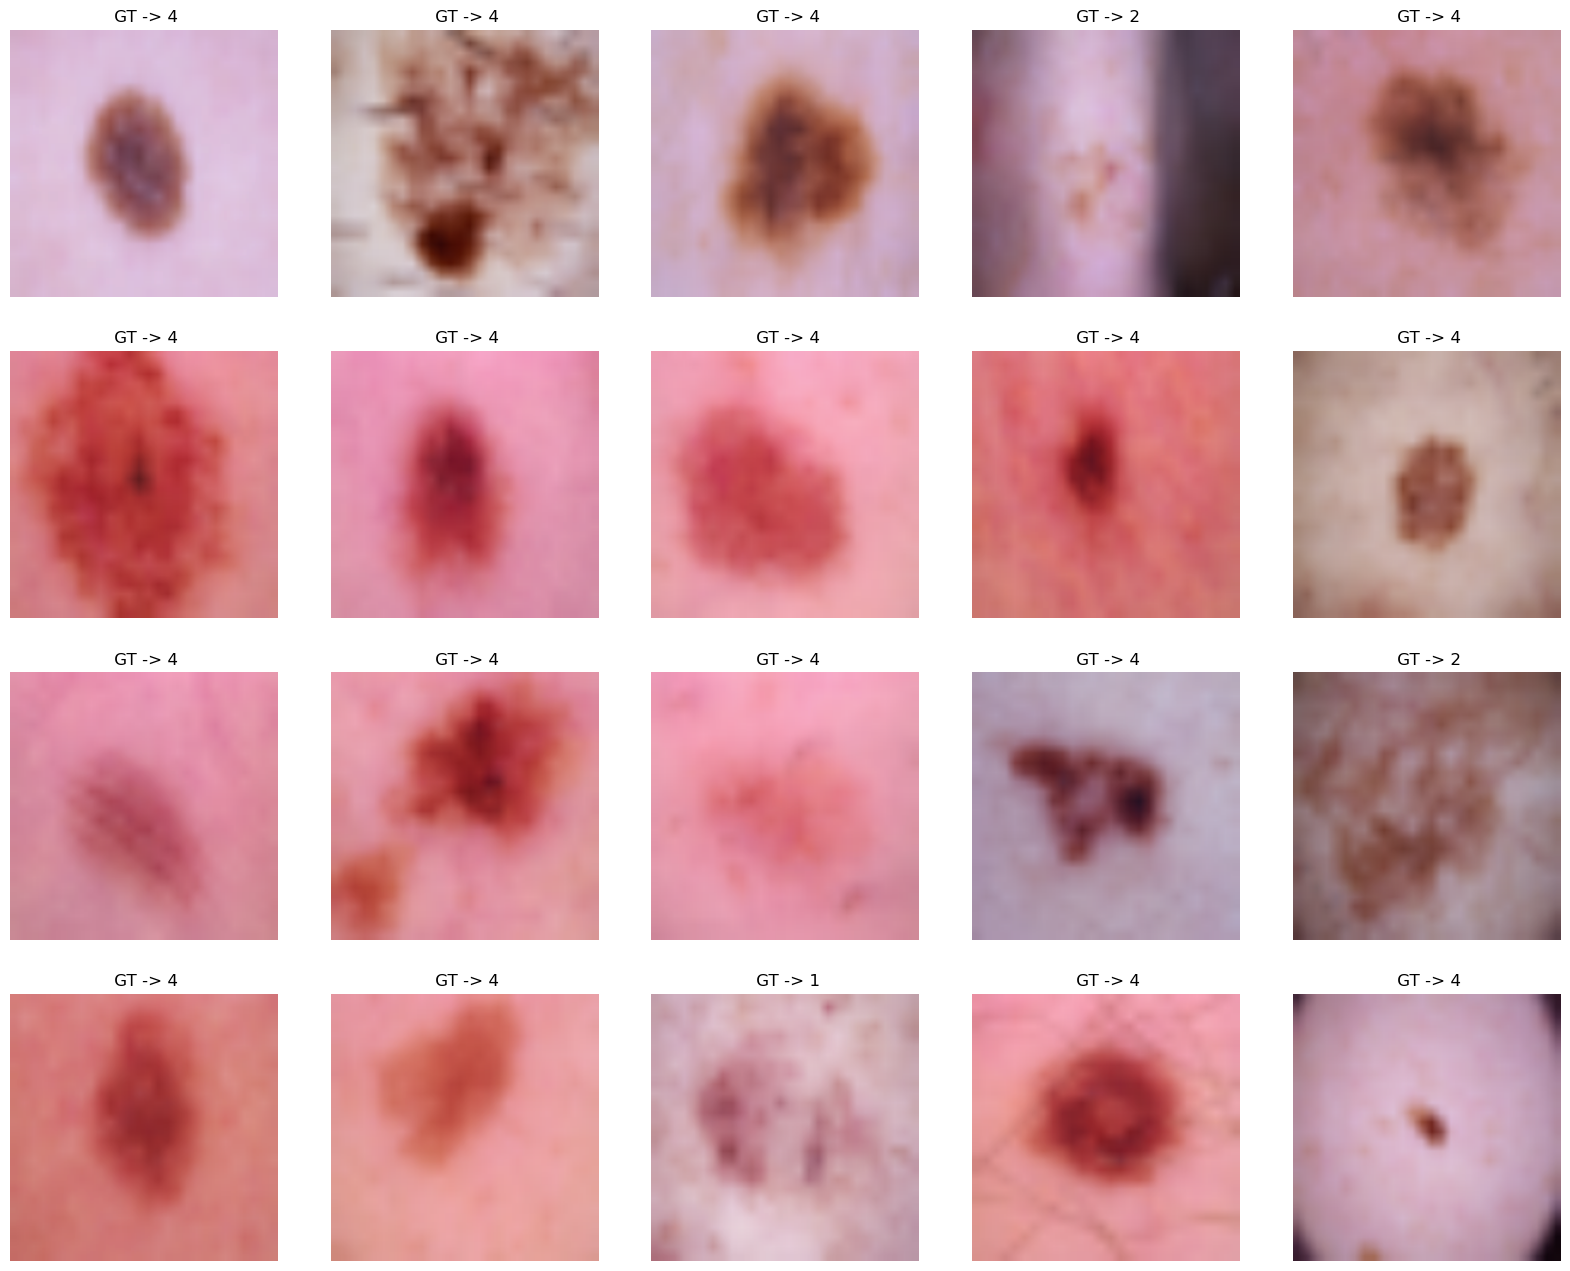

In [30]:
Visualize(data = tr_dl.dataset, rows = 4, num_imgs=20, class_names = list(class_names.keys()))


In [31]:
device = "cuda"if torch.cuda.is_available() else "cpu"
def tic_toc(start_time=None):
    return time.time() if start_time is None else time.time() - start_time

# Train

In [32]:
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import Subset
from sklearn.metrics import f1_score, roc_auc_score, matthews_corrcoef
from tqdm import tqdm
import timm
import pickle
random_seed(42)

def train(model, tr_dl, val_dl, loss_fn, opt, device, epochs, save, threshold):
    # Train matrix
    tr_acc_sc = []
    tr_loss_sc = []
    tr_f1_sc = []
    tr_auc_sc = []
    tr_mcc_sc = []
    # validation matrix
    val_acc_sc = []
    val_loss_sc = []
    val_f1_sc = []
    val_auc_sc = []
    val_mcc_sc = []

    best_loss = np.inf
    train_start = tic_toc()
    save_dir = "Skin_save_model_rexnet_"
    not_impoved, patience = 0, 10

    for epoch in range(epochs):
        tic = tic_toc()
        print(f"{epoch+1} - Train is starting ...")
        model.train()
        tr_epoch_loss, tr_epoch_acc = 0,0
        tr_probs, tr_labels, tr_preds = [],[],[]

        for idx, batch in enumerate(tqdm(tr_dl)):
            im, gt = batch
            im, gt = im.to(device), gt.to(device)
            pred = model(im)
            loss = loss_fn(pred, gt)
            tr_epoch_loss+=loss.item()

            pred_classes = torch.argmax(pred, dim=1)
            tr_epoch_acc += (pred_classes == gt).sum().item()

            tr_probs.extend(torch.softmax(pred, dim = 1).detach().cpu().numpy())
            tr_labels.extend(gt.cpu().numpy())
            tr_preds.extend(pred_classes.cpu().numpy())

            opt.zero_grad()
            loss.backward()
            opt.step()

        tr_epoch_acc /= len(tr_dl.dataset)
        tr_epoch_loss /= len(tr_dl)
        
        tr_auc = roc_auc_score(tr_labels, tr_probs, multi_class="ovo")
        f1_sc = f1_score(tr_labels, tr_preds, average='weighted')
        tr_mcc = matthews_corrcoef(tr_labels, tr_preds)

        tr_acc_sc.append(tr_epoch_acc) 
        tr_loss_sc.append(tr_epoch_loss)
        tr_f1_sc.append(f1_sc)
        tr_auc_sc.append(tr_auc)
        tr_mcc_sc.append(tr_mcc)

        # Validation
        model.eval()
        with torch.no_grad():
            val_epoch_loss, val_epoch_acc = 0,0
            val_probs, val_labels, val_preds = [],[],[]
            for idx, batch in enumerate(tqdm(val_dl)):
                im, gt = batch
                im, gt = im.to(device), gt.to(device)
                pred = model(im)
                loss  = loss_fn(pred, gt)
                
                val_epoch_loss+= loss.item()
                pred_class = torch.argmax(pred, dim = 1)
                val_epoch_acc += (pred_class == gt).sum().item()
                
                val_probs.extend(torch.softmax(pred, dim =1).detach().cpu().numpy())
                val_labels.extend(gt.cpu().numpy())
                val_preds.extend(pred_class.cpu().numpy())
        

            val_epoch_acc/= len(val_dl.dataset)
            val_epoch_loss /= len(val_dl)

            val_auc = roc_auc_score(val_labels,val_probs, multi_class="ovo")
            vf1_sc = f1_score(val_labels, val_preds, average='weighted')
            val_mcc = matthews_corrcoef(val_labels, val_preds)
            
            val_acc_sc.append(val_epoch_acc)
            val_loss_sc.append(val_epoch_loss)
            val_f1_sc.append(vf1_sc)
            val_auc_sc.append(val_auc) 
            val_mcc_sc.append(val_mcc)


            print(f"{epoch + 1} - Epoch Train process results:")
            print(f" Training time -> {tic_toc(tic):.3f} sec")
            print(f"{epoch +1} - Epoch Train Accuracy score       - > {tr_epoch_acc:.3f}")
            print(f"{epoch +1} - Epoch Train Loss score           - > {tr_epoch_loss:.3f}")
            print(f"{epoch+1} -  Epoch Train AUC                  - > {tr_auc:.3f}")
            print(f"{epoch+1} -  Epoch Train MCC                  - > {tr_mcc:.3f}")
            print(f"{epoch+1} -  Epoch Train F1                   - > {f1_sc:.3f}")
            print(f"{epoch +1} - Epoch Validation process results:")
            print(f"{epoch +1} - Epoch Validation Accuracy score  - > {val_epoch_acc:.3f}")
            print(f"{epoch +1} - Epoch Validation Loss score      - > {val_epoch_loss:.3f}") 
            print(f"{epoch+1} -  Epoch Train AUC                  - > {val_auc:.3f}")
            print(f"{epoch+1} -  Epoch Train MCC                  - > {val_mcc:.3f}")
            print(f"{epoch+1} -  Epoch Train F1                   - > {vf1_sc:.3f}")

            if val_epoch_loss < (best_loss + threshold):
                best_loss = val_epoch_loss
                os.makedirs(save_dir, exist_ok= True)
                torch.save(model.state_dict(), f"{save_dir}/{save}_best_model.pth")
                print(f"{epoch+1} -   SAVED: {save_dir}/{save}_best_model.pth")
                
    return {
        "tr_loss_acc": tr_loss_sc, "tr_acc_sc": tr_acc_sc, "tr_auc_sc": tr_auc_sc, "tr_f1_sc": tr_f1_sc, "tr_mcc_sc" : tr_mcc_sc,
        "val_loss_acc": val_loss_sc, "val_acc_sc": val_acc_sc, "val_auc_sc": val_auc_sc, "val_f1_sc": val_f1_sc,"val_mcc_sc" : val_mcc_sc}
                      

# Train without k-fold

In [33]:
model = timm.create_model("rexnet_150", pretrained= True,  num_classes = len(class_names))
# model = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=len(class_names))
model.to(device)
loss_fn = CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
result = train(
        model = model,
        tr_dl = tr_dl,
        val_dl = val_dl,
        loss_fn = loss_fn,
        opt = optimizer,
        device = device,
        epochs = 50,
        save = f"pkd4_fold{fold+1}",
        threshold = 0.0001)

1 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 25.17it/s]


1 - Epoch Train process results:
 Training time -> 18.036 sec
1 - Epoch Train Accuracy score       - > 0.703
1 - Epoch Train Loss score           - > 0.927
1 -  Epoch Train AUC                  - > 0.798
1 -  Epoch Train MCC                  - > 0.408
1 -  Epoch Train F1                   - > 0.693
1 - Epoch Validation process results:
1 - Epoch Validation Accuracy score  - > 0.767
1 - Epoch Validation Loss score      - > 0.624
1 -  Epoch Train AUC                  - > 0.889
1 -  Epoch Train MCC                  - > 0.499
1 -  Epoch Train F1                   - > 0.734
1 -   SAVED: Skin_save_model_rexnet_/pkd4_fold5_best_model.pth
2 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 24.56it/s]


2 - Epoch Train process results:
 Training time -> 18.798 sec
2 - Epoch Train Accuracy score       - > 0.787
2 - Epoch Train Loss score           - > 0.588
2 -  Epoch Train AUC                  - > 0.907
2 -  Epoch Train MCC                  - > 0.579
2 -  Epoch Train F1                   - > 0.780
2 - Epoch Validation process results:
2 - Epoch Validation Accuracy score  - > 0.791
2 - Epoch Validation Loss score      - > 0.636
2 -  Epoch Train AUC                  - > 0.890
2 -  Epoch Train MCC                  - > 0.554
2 -  Epoch Train F1                   - > 0.769
3 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 27.48it/s]


3 - Epoch Train process results:
 Training time -> 18.030 sec
3 - Epoch Train Accuracy score       - > 0.826
3 - Epoch Train Loss score           - > 0.470
3 -  Epoch Train AUC                  - > 0.944
3 -  Epoch Train MCC                  - > 0.659
3 -  Epoch Train F1                   - > 0.822
3 - Epoch Validation process results:
3 - Epoch Validation Accuracy score  - > 0.800
3 - Epoch Validation Loss score      - > 0.571
3 -  Epoch Train AUC                  - > 0.907
3 -  Epoch Train MCC                  - > 0.579
3 -  Epoch Train F1                   - > 0.783
3 -   SAVED: Skin_save_model_rexnet_/pkd4_fold5_best_model.pth
4 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 26.24it/s]


4 - Epoch Train process results:
 Training time -> 17.163 sec
4 - Epoch Train Accuracy score       - > 0.875
4 - Epoch Train Loss score           - > 0.349
4 -  Epoch Train AUC                  - > 0.972
4 -  Epoch Train MCC                  - > 0.758
4 -  Epoch Train F1                   - > 0.874
4 - Epoch Validation process results:
4 - Epoch Validation Accuracy score  - > 0.787
4 - Epoch Validation Loss score      - > 0.649
4 -  Epoch Train AUC                  - > 0.899
4 -  Epoch Train MCC                  - > 0.539
4 -  Epoch Train F1                   - > 0.757
5 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 27.06it/s]


5 - Epoch Train process results:
 Training time -> 16.987 sec
5 - Epoch Train Accuracy score       - > 0.903
5 - Epoch Train Loss score           - > 0.278
5 -  Epoch Train AUC                  - > 0.983
5 -  Epoch Train MCC                  - > 0.812
5 -  Epoch Train F1                   - > 0.902
5 - Epoch Validation process results:
5 - Epoch Validation Accuracy score  - > 0.799
5 - Epoch Validation Loss score      - > 0.697
5 -  Epoch Train AUC                  - > 0.895
5 -  Epoch Train MCC                  - > 0.584
5 -  Epoch Train F1                   - > 0.784
6 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 27.36it/s]


6 - Epoch Train process results:
 Training time -> 17.023 sec
6 - Epoch Train Accuracy score       - > 0.922
6 - Epoch Train Loss score           - > 0.214
6 -  Epoch Train AUC                  - > 0.990
6 -  Epoch Train MCC                  - > 0.850
6 -  Epoch Train F1                   - > 0.922
6 - Epoch Validation process results:
6 - Epoch Validation Accuracy score  - > 0.791
6 - Epoch Validation Loss score      - > 0.793
6 -  Epoch Train AUC                  - > 0.900
6 -  Epoch Train MCC                  - > 0.599
6 -  Epoch Train F1                   - > 0.786
7 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 26.44it/s]


7 - Epoch Train process results:
 Training time -> 18.014 sec
7 - Epoch Train Accuracy score       - > 0.930
7 - Epoch Train Loss score           - > 0.199
7 -  Epoch Train AUC                  - > 0.991
7 -  Epoch Train MCC                  - > 0.866
7 -  Epoch Train F1                   - > 0.930
7 - Epoch Validation process results:
7 - Epoch Validation Accuracy score  - > 0.799
7 - Epoch Validation Loss score      - > 0.666
7 -  Epoch Train AUC                  - > 0.920
7 -  Epoch Train MCC                  - > 0.614
7 -  Epoch Train F1                   - > 0.801
8 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 27.65it/s]


8 - Epoch Train process results:
 Training time -> 16.873 sec
8 - Epoch Train Accuracy score       - > 0.948
8 - Epoch Train Loss score           - > 0.151
8 -  Epoch Train AUC                  - > 0.994
8 -  Epoch Train MCC                  - > 0.900
8 -  Epoch Train F1                   - > 0.948
8 - Epoch Validation process results:
8 - Epoch Validation Accuracy score  - > 0.794
8 - Epoch Validation Loss score      - > 0.954
8 -  Epoch Train AUC                  - > 0.903
8 -  Epoch Train MCC                  - > 0.568
8 -  Epoch Train F1                   - > 0.771
9 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 25.61it/s]


9 - Epoch Train process results:
 Training time -> 16.894 sec
9 - Epoch Train Accuracy score       - > 0.953
9 - Epoch Train Loss score           - > 0.133
9 -  Epoch Train AUC                  - > 0.996
9 -  Epoch Train MCC                  - > 0.909
9 -  Epoch Train F1                   - > 0.952
9 - Epoch Validation process results:
9 - Epoch Validation Accuracy score  - > 0.802
9 - Epoch Validation Loss score      - > 0.783
9 -  Epoch Train AUC                  - > 0.915
9 -  Epoch Train MCC                  - > 0.610
9 -  Epoch Train F1                   - > 0.795
10 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 25.86it/s]


10 - Epoch Train process results:
 Training time -> 17.042 sec
10 - Epoch Train Accuracy score       - > 0.959
10 - Epoch Train Loss score           - > 0.116
10 -  Epoch Train AUC                  - > 0.997
10 -  Epoch Train MCC                  - > 0.921
10 -  Epoch Train F1                   - > 0.959
10 - Epoch Validation process results:
10 - Epoch Validation Accuracy score  - > 0.805
10 - Epoch Validation Loss score      - > 0.818
10 -  Epoch Train AUC                  - > 0.906
10 -  Epoch Train MCC                  - > 0.606
10 -  Epoch Train F1                   - > 0.799
11 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 26.02it/s]


11 - Epoch Train process results:
 Training time -> 17.918 sec
11 - Epoch Train Accuracy score       - > 0.955
11 - Epoch Train Loss score           - > 0.131
11 -  Epoch Train AUC                  - > 0.996
11 -  Epoch Train MCC                  - > 0.913
11 -  Epoch Train F1                   - > 0.955
11 - Epoch Validation process results:
11 - Epoch Validation Accuracy score  - > 0.815
11 - Epoch Validation Loss score      - > 0.707
11 -  Epoch Train AUC                  - > 0.915
11 -  Epoch Train MCC                  - > 0.645
11 -  Epoch Train F1                   - > 0.816
12 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 25.83it/s]


12 - Epoch Train process results:
 Training time -> 17.113 sec
12 - Epoch Train Accuracy score       - > 0.963
12 - Epoch Train Loss score           - > 0.106
12 -  Epoch Train AUC                  - > 0.997
12 -  Epoch Train MCC                  - > 0.929
12 -  Epoch Train F1                   - > 0.963
12 - Epoch Validation process results:
12 - Epoch Validation Accuracy score  - > 0.817
12 - Epoch Validation Loss score      - > 0.856
12 -  Epoch Train AUC                  - > 0.928
12 -  Epoch Train MCC                  - > 0.641
12 -  Epoch Train F1                   - > 0.813
13 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 26.02it/s]


13 - Epoch Train process results:
 Training time -> 17.631 sec
13 - Epoch Train Accuracy score       - > 0.965
13 - Epoch Train Loss score           - > 0.104
13 -  Epoch Train AUC                  - > 0.997
13 -  Epoch Train MCC                  - > 0.932
13 -  Epoch Train F1                   - > 0.965
13 - Epoch Validation process results:
13 - Epoch Validation Accuracy score  - > 0.791
13 - Epoch Validation Loss score      - > 1.060
13 -  Epoch Train AUC                  - > 0.916
13 -  Epoch Train MCC                  - > 0.561
13 -  Epoch Train F1                   - > 0.771
14 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 26.47it/s]


14 - Epoch Train process results:
 Training time -> 17.467 sec
14 - Epoch Train Accuracy score       - > 0.974
14 - Epoch Train Loss score           - > 0.079
14 -  Epoch Train AUC                  - > 0.999
14 -  Epoch Train MCC                  - > 0.950
14 -  Epoch Train F1                   - > 0.974
14 - Epoch Validation process results:
14 - Epoch Validation Accuracy score  - > 0.822
14 - Epoch Validation Loss score      - > 0.797
14 -  Epoch Train AUC                  - > 0.923
14 -  Epoch Train MCC                  - > 0.645
14 -  Epoch Train F1                   - > 0.819
15 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 25.76it/s]


15 - Epoch Train process results:
 Training time -> 17.022 sec
15 - Epoch Train Accuracy score       - > 0.974
15 - Epoch Train Loss score           - > 0.075
15 -  Epoch Train AUC                  - > 0.999
15 -  Epoch Train MCC                  - > 0.951
15 -  Epoch Train F1                   - > 0.974
15 - Epoch Validation process results:
15 - Epoch Validation Accuracy score  - > 0.815
15 - Epoch Validation Loss score      - > 0.807
15 -  Epoch Train AUC                  - > 0.924
15 -  Epoch Train MCC                  - > 0.629
15 -  Epoch Train F1                   - > 0.809
16 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 27.26it/s]


16 - Epoch Train process results:
 Training time -> 17.310 sec
16 - Epoch Train Accuracy score       - > 0.976
16 - Epoch Train Loss score           - > 0.071
16 -  Epoch Train AUC                  - > 0.999
16 -  Epoch Train MCC                  - > 0.954
16 -  Epoch Train F1                   - > 0.976
16 - Epoch Validation process results:
16 - Epoch Validation Accuracy score  - > 0.798
16 - Epoch Validation Loss score      - > 0.966
16 -  Epoch Train AUC                  - > 0.908
16 -  Epoch Train MCC                  - > 0.592
16 -  Epoch Train F1                   - > 0.791
17 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 25.81it/s]


17 - Epoch Train process results:
 Training time -> 17.032 sec
17 - Epoch Train Accuracy score       - > 0.978
17 - Epoch Train Loss score           - > 0.059
17 -  Epoch Train AUC                  - > 0.999
17 -  Epoch Train MCC                  - > 0.957
17 -  Epoch Train F1                   - > 0.978
17 - Epoch Validation process results:
17 - Epoch Validation Accuracy score  - > 0.808
17 - Epoch Validation Loss score      - > 0.826
17 -  Epoch Train AUC                  - > 0.902
17 -  Epoch Train MCC                  - > 0.610
17 -  Epoch Train F1                   - > 0.800
18 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 25.96it/s]


18 - Epoch Train process results:
 Training time -> 17.217 sec
18 - Epoch Train Accuracy score       - > 0.954
18 - Epoch Train Loss score           - > 0.139
18 -  Epoch Train AUC                  - > 0.995
18 -  Epoch Train MCC                  - > 0.912
18 -  Epoch Train F1                   - > 0.954
18 - Epoch Validation process results:
18 - Epoch Validation Accuracy score  - > 0.788
18 - Epoch Validation Loss score      - > 0.981
18 -  Epoch Train AUC                  - > 0.881
18 -  Epoch Train MCC                  - > 0.551
18 -  Epoch Train F1                   - > 0.765
19 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 25.92it/s]


19 - Epoch Train process results:
 Training time -> 18.342 sec
19 - Epoch Train Accuracy score       - > 0.972
19 - Epoch Train Loss score           - > 0.074
19 -  Epoch Train AUC                  - > 0.998
19 -  Epoch Train MCC                  - > 0.947
19 -  Epoch Train F1                   - > 0.972
19 - Epoch Validation process results:
19 - Epoch Validation Accuracy score  - > 0.793
19 - Epoch Validation Loss score      - > 0.910
19 -  Epoch Train AUC                  - > 0.918
19 -  Epoch Train MCC                  - > 0.609
19 -  Epoch Train F1                   - > 0.797
20 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 25.66it/s]


20 - Epoch Train process results:
 Training time -> 17.334 sec
20 - Epoch Train Accuracy score       - > 0.976
20 - Epoch Train Loss score           - > 0.067
20 -  Epoch Train AUC                  - > 0.999
20 -  Epoch Train MCC                  - > 0.955
20 -  Epoch Train F1                   - > 0.976
20 - Epoch Validation process results:
20 - Epoch Validation Accuracy score  - > 0.809
20 - Epoch Validation Loss score      - > 0.842
20 -  Epoch Train AUC                  - > 0.917
20 -  Epoch Train MCC                  - > 0.611
20 -  Epoch Train F1                   - > 0.798
21 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 26.15it/s]


21 - Epoch Train process results:
 Training time -> 17.066 sec
21 - Epoch Train Accuracy score       - > 0.981
21 - Epoch Train Loss score           - > 0.057
21 -  Epoch Train AUC                  - > 0.999
21 -  Epoch Train MCC                  - > 0.964
21 -  Epoch Train F1                   - > 0.981
21 - Epoch Validation process results:
21 - Epoch Validation Accuracy score  - > 0.814
21 - Epoch Validation Loss score      - > 0.923
21 -  Epoch Train AUC                  - > 0.919
21 -  Epoch Train MCC                  - > 0.614
21 -  Epoch Train F1                   - > 0.798
22 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 24.77it/s]


22 - Epoch Train process results:
 Training time -> 17.500 sec
22 - Epoch Train Accuracy score       - > 0.985
22 - Epoch Train Loss score           - > 0.050
22 -  Epoch Train AUC                  - > 0.999
22 -  Epoch Train MCC                  - > 0.972
22 -  Epoch Train F1                   - > 0.985
22 - Epoch Validation process results:
22 - Epoch Validation Accuracy score  - > 0.817
22 - Epoch Validation Loss score      - > 0.895
22 -  Epoch Train AUC                  - > 0.926
22 -  Epoch Train MCC                  - > 0.651
22 -  Epoch Train F1                   - > 0.818
23 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 26.59it/s]


23 - Epoch Train process results:
 Training time -> 17.357 sec
23 - Epoch Train Accuracy score       - > 0.987
23 - Epoch Train Loss score           - > 0.039
23 -  Epoch Train AUC                  - > 1.000
23 -  Epoch Train MCC                  - > 0.975
23 -  Epoch Train F1                   - > 0.987
23 - Epoch Validation process results:
23 - Epoch Validation Accuracy score  - > 0.782
23 - Epoch Validation Loss score      - > 1.038
23 -  Epoch Train AUC                  - > 0.915
23 -  Epoch Train MCC                  - > 0.571
23 -  Epoch Train F1                   - > 0.778
24 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 26.87it/s]


24 - Epoch Train process results:
 Training time -> 18.614 sec
24 - Epoch Train Accuracy score       - > 0.967
24 - Epoch Train Loss score           - > 0.096
24 -  Epoch Train AUC                  - > 0.998
24 -  Epoch Train MCC                  - > 0.937
24 -  Epoch Train F1                   - > 0.967
24 - Epoch Validation process results:
24 - Epoch Validation Accuracy score  - > 0.803
24 - Epoch Validation Loss score      - > 0.914
24 -  Epoch Train AUC                  - > 0.895
24 -  Epoch Train MCC                  - > 0.597
24 -  Epoch Train F1                   - > 0.794
25 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 25.08it/s]


25 - Epoch Train process results:
 Training time -> 18.023 sec
25 - Epoch Train Accuracy score       - > 0.975
25 - Epoch Train Loss score           - > 0.074
25 -  Epoch Train AUC                  - > 0.999
25 -  Epoch Train MCC                  - > 0.952
25 -  Epoch Train F1                   - > 0.975
25 - Epoch Validation process results:
25 - Epoch Validation Accuracy score  - > 0.812
25 - Epoch Validation Loss score      - > 0.947
25 -  Epoch Train AUC                  - > 0.927
25 -  Epoch Train MCC                  - > 0.631
25 -  Epoch Train F1                   - > 0.810
26 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 28.76it/s]


26 - Epoch Train process results:
 Training time -> 18.451 sec
26 - Epoch Train Accuracy score       - > 0.989
26 - Epoch Train Loss score           - > 0.035
26 -  Epoch Train AUC                  - > 1.000
26 -  Epoch Train MCC                  - > 0.979
26 -  Epoch Train F1                   - > 0.989
26 - Epoch Validation process results:
26 - Epoch Validation Accuracy score  - > 0.806
26 - Epoch Validation Loss score      - > 1.033
26 -  Epoch Train AUC                  - > 0.927
26 -  Epoch Train MCC                  - > 0.608
26 -  Epoch Train F1                   - > 0.795
27 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 27.00it/s]


27 - Epoch Train process results:
 Training time -> 18.269 sec
27 - Epoch Train Accuracy score       - > 0.981
27 - Epoch Train Loss score           - > 0.050
27 -  Epoch Train AUC                  - > 0.999
27 -  Epoch Train MCC                  - > 0.963
27 -  Epoch Train F1                   - > 0.981
27 - Epoch Validation process results:
27 - Epoch Validation Accuracy score  - > 0.802
27 - Epoch Validation Loss score      - > 0.982
27 -  Epoch Train AUC                  - > 0.913
27 -  Epoch Train MCC                  - > 0.608
27 -  Epoch Train F1                   - > 0.801
28 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 25.16it/s]


28 - Epoch Train process results:
 Training time -> 18.233 sec
28 - Epoch Train Accuracy score       - > 0.981
28 - Epoch Train Loss score           - > 0.057
28 -  Epoch Train AUC                  - > 0.999
28 -  Epoch Train MCC                  - > 0.963
28 -  Epoch Train F1                   - > 0.981
28 - Epoch Validation process results:
28 - Epoch Validation Accuracy score  - > 0.813
28 - Epoch Validation Loss score      - > 1.062
28 -  Epoch Train AUC                  - > 0.917
28 -  Epoch Train MCC                  - > 0.629
28 -  Epoch Train F1                   - > 0.805
29 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 25.30it/s]


29 - Epoch Train process results:
 Training time -> 18.415 sec
29 - Epoch Train Accuracy score       - > 0.984
29 - Epoch Train Loss score           - > 0.047
29 -  Epoch Train AUC                  - > 0.999
29 -  Epoch Train MCC                  - > 0.970
29 -  Epoch Train F1                   - > 0.984
29 - Epoch Validation process results:
29 - Epoch Validation Accuracy score  - > 0.808
29 - Epoch Validation Loss score      - > 1.077
29 -  Epoch Train AUC                  - > 0.909
29 -  Epoch Train MCC                  - > 0.604
29 -  Epoch Train F1                   - > 0.798
30 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 23.23it/s]


30 - Epoch Train process results:
 Training time -> 18.386 sec
30 - Epoch Train Accuracy score       - > 0.981
30 - Epoch Train Loss score           - > 0.056
30 -  Epoch Train AUC                  - > 0.999
30 -  Epoch Train MCC                  - > 0.964
30 -  Epoch Train F1                   - > 0.981
30 - Epoch Validation process results:
30 - Epoch Validation Accuracy score  - > 0.807
30 - Epoch Validation Loss score      - > 0.966
30 -  Epoch Train AUC                  - > 0.913
30 -  Epoch Train MCC                  - > 0.623
30 -  Epoch Train F1                   - > 0.806
31 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 28.43it/s]


31 - Epoch Train process results:
 Training time -> 17.956 sec
31 - Epoch Train Accuracy score       - > 0.989
31 - Epoch Train Loss score           - > 0.033
31 -  Epoch Train AUC                  - > 1.000
31 -  Epoch Train MCC                  - > 0.978
31 -  Epoch Train F1                   - > 0.989
31 - Epoch Validation process results:
31 - Epoch Validation Accuracy score  - > 0.799
31 - Epoch Validation Loss score      - > 1.140
31 -  Epoch Train AUC                  - > 0.907
31 -  Epoch Train MCC                  - > 0.607
31 -  Epoch Train F1                   - > 0.795
32 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 24.05it/s]


32 - Epoch Train process results:
 Training time -> 18.361 sec
32 - Epoch Train Accuracy score       - > 0.986
32 - Epoch Train Loss score           - > 0.046
32 -  Epoch Train AUC                  - > 0.999
32 -  Epoch Train MCC                  - > 0.973
32 -  Epoch Train F1                   - > 0.986
32 - Epoch Validation process results:
32 - Epoch Validation Accuracy score  - > 0.795
32 - Epoch Validation Loss score      - > 1.362
32 -  Epoch Train AUC                  - > 0.879
32 -  Epoch Train MCC                  - > 0.571
32 -  Epoch Train F1                   - > 0.781
33 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 22.72it/s]


33 - Epoch Train process results:
 Training time -> 19.018 sec
33 - Epoch Train Accuracy score       - > 0.981
33 - Epoch Train Loss score           - > 0.056
33 -  Epoch Train AUC                  - > 0.999
33 -  Epoch Train MCC                  - > 0.964
33 -  Epoch Train F1                   - > 0.981
33 - Epoch Validation process results:
33 - Epoch Validation Accuracy score  - > 0.823
33 - Epoch Validation Loss score      - > 1.123
33 -  Epoch Train AUC                  - > 0.917
33 -  Epoch Train MCC                  - > 0.643
33 -  Epoch Train F1                   - > 0.816
34 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 26.40it/s]


34 - Epoch Train process results:
 Training time -> 18.529 sec
34 - Epoch Train Accuracy score       - > 0.977
34 - Epoch Train Loss score           - > 0.062
34 -  Epoch Train AUC                  - > 0.999
34 -  Epoch Train MCC                  - > 0.956
34 -  Epoch Train F1                   - > 0.977
34 - Epoch Validation process results:
34 - Epoch Validation Accuracy score  - > 0.808
34 - Epoch Validation Loss score      - > 1.210
34 -  Epoch Train AUC                  - > 0.902
34 -  Epoch Train MCC                  - > 0.608
34 -  Epoch Train F1                   - > 0.800
35 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 25.43it/s]


35 - Epoch Train process results:
 Training time -> 17.933 sec
35 - Epoch Train Accuracy score       - > 0.982
35 - Epoch Train Loss score           - > 0.053
35 -  Epoch Train AUC                  - > 0.999
35 -  Epoch Train MCC                  - > 0.966
35 -  Epoch Train F1                   - > 0.982
35 - Epoch Validation process results:
35 - Epoch Validation Accuracy score  - > 0.817
35 - Epoch Validation Loss score      - > 1.194
35 -  Epoch Train AUC                  - > 0.912
35 -  Epoch Train MCC                  - > 0.620
35 -  Epoch Train F1                   - > 0.804
36 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 26.26it/s]


36 - Epoch Train process results:
 Training time -> 17.573 sec
36 - Epoch Train Accuracy score       - > 0.985
36 - Epoch Train Loss score           - > 0.042
36 -  Epoch Train AUC                  - > 1.000
36 -  Epoch Train MCC                  - > 0.972
36 -  Epoch Train F1                   - > 0.985
36 - Epoch Validation process results:
36 - Epoch Validation Accuracy score  - > 0.814
36 - Epoch Validation Loss score      - > 1.163
36 -  Epoch Train AUC                  - > 0.918
36 -  Epoch Train MCC                  - > 0.620
36 -  Epoch Train F1                   - > 0.804
37 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 26.33it/s]


37 - Epoch Train process results:
 Training time -> 17.901 sec
37 - Epoch Train Accuracy score       - > 0.992
37 - Epoch Train Loss score           - > 0.023
37 -  Epoch Train AUC                  - > 1.000
37 -  Epoch Train MCC                  - > 0.984
37 -  Epoch Train F1                   - > 0.992
37 - Epoch Validation process results:
37 - Epoch Validation Accuracy score  - > 0.801
37 - Epoch Validation Loss score      - > 1.187
37 -  Epoch Train AUC                  - > 0.902
37 -  Epoch Train MCC                  - > 0.591
37 -  Epoch Train F1                   - > 0.790
38 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 25.92it/s]


38 - Epoch Train process results:
 Training time -> 17.585 sec
38 - Epoch Train Accuracy score       - > 0.991
38 - Epoch Train Loss score           - > 0.028
38 -  Epoch Train AUC                  - > 1.000
38 -  Epoch Train MCC                  - > 0.983
38 -  Epoch Train F1                   - > 0.991
38 - Epoch Validation process results:
38 - Epoch Validation Accuracy score  - > 0.810
38 - Epoch Validation Loss score      - > 1.173
38 -  Epoch Train AUC                  - > 0.910
38 -  Epoch Train MCC                  - > 0.610
38 -  Epoch Train F1                   - > 0.801
39 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 27.43it/s]


39 - Epoch Train process results:
 Training time -> 16.999 sec
39 - Epoch Train Accuracy score       - > 0.988
39 - Epoch Train Loss score           - > 0.035
39 -  Epoch Train AUC                  - > 0.999
39 -  Epoch Train MCC                  - > 0.977
39 -  Epoch Train F1                   - > 0.988
39 - Epoch Validation process results:
39 - Epoch Validation Accuracy score  - > 0.783
39 - Epoch Validation Loss score      - > 1.104
39 -  Epoch Train AUC                  - > 0.908
39 -  Epoch Train MCC                  - > 0.574
39 -  Epoch Train F1                   - > 0.782
40 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 26.84it/s]


40 - Epoch Train process results:
 Training time -> 17.284 sec
40 - Epoch Train Accuracy score       - > 0.980
40 - Epoch Train Loss score           - > 0.061
40 -  Epoch Train AUC                  - > 0.999
40 -  Epoch Train MCC                  - > 0.961
40 -  Epoch Train F1                   - > 0.980
40 - Epoch Validation process results:
40 - Epoch Validation Accuracy score  - > 0.804
40 - Epoch Validation Loss score      - > 0.936
40 -  Epoch Train AUC                  - > 0.924
40 -  Epoch Train MCC                  - > 0.614
40 -  Epoch Train F1                   - > 0.800
41 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 22.53it/s]


41 - Epoch Train process results:
 Training time -> 17.905 sec
41 - Epoch Train Accuracy score       - > 0.989
41 - Epoch Train Loss score           - > 0.031
41 -  Epoch Train AUC                  - > 1.000
41 -  Epoch Train MCC                  - > 0.979
41 -  Epoch Train F1                   - > 0.989
41 - Epoch Validation process results:
41 - Epoch Validation Accuracy score  - > 0.806
41 - Epoch Validation Loss score      - > 1.280
41 -  Epoch Train AUC                  - > 0.908
41 -  Epoch Train MCC                  - > 0.610
41 -  Epoch Train F1                   - > 0.796
42 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 25.99it/s]


42 - Epoch Train process results:
 Training time -> 17.690 sec
42 - Epoch Train Accuracy score       - > 0.988
42 - Epoch Train Loss score           - > 0.038
42 -  Epoch Train AUC                  - > 0.999
42 -  Epoch Train MCC                  - > 0.977
42 -  Epoch Train F1                   - > 0.988
42 - Epoch Validation process results:
42 - Epoch Validation Accuracy score  - > 0.812
42 - Epoch Validation Loss score      - > 1.232
42 -  Epoch Train AUC                  - > 0.898
42 -  Epoch Train MCC                  - > 0.617
42 -  Epoch Train F1                   - > 0.800
43 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 26.32it/s]


43 - Epoch Train process results:
 Training time -> 17.412 sec
43 - Epoch Train Accuracy score       - > 0.982
43 - Epoch Train Loss score           - > 0.052
43 -  Epoch Train AUC                  - > 0.999
43 -  Epoch Train MCC                  - > 0.966
43 -  Epoch Train F1                   - > 0.982
43 - Epoch Validation process results:
43 - Epoch Validation Accuracy score  - > 0.789
43 - Epoch Validation Loss score      - > 1.202
43 -  Epoch Train AUC                  - > 0.898
43 -  Epoch Train MCC                  - > 0.570
43 -  Epoch Train F1                   - > 0.778
44 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 26.70it/s]


44 - Epoch Train process results:
 Training time -> 17.856 sec
44 - Epoch Train Accuracy score       - > 0.984
44 - Epoch Train Loss score           - > 0.050
44 -  Epoch Train AUC                  - > 0.999
44 -  Epoch Train MCC                  - > 0.969
44 -  Epoch Train F1                   - > 0.984
44 - Epoch Validation process results:
44 - Epoch Validation Accuracy score  - > 0.793
44 - Epoch Validation Loss score      - > 1.229
44 -  Epoch Train AUC                  - > 0.898
44 -  Epoch Train MCC                  - > 0.576
44 -  Epoch Train F1                   - > 0.782
45 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 25.67it/s]


45 - Epoch Train process results:
 Training time -> 18.138 sec
45 - Epoch Train Accuracy score       - > 0.986
45 - Epoch Train Loss score           - > 0.044
45 -  Epoch Train AUC                  - > 1.000
45 -  Epoch Train MCC                  - > 0.972
45 -  Epoch Train F1                   - > 0.986
45 - Epoch Validation process results:
45 - Epoch Validation Accuracy score  - > 0.805
45 - Epoch Validation Loss score      - > 1.213
45 -  Epoch Train AUC                  - > 0.906
45 -  Epoch Train MCC                  - > 0.605
45 -  Epoch Train F1                   - > 0.798
46 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 23.46it/s]


46 - Epoch Train process results:
 Training time -> 18.404 sec
46 - Epoch Train Accuracy score       - > 0.995
46 - Epoch Train Loss score           - > 0.013
46 -  Epoch Train AUC                  - > 1.000
46 -  Epoch Train MCC                  - > 0.991
46 -  Epoch Train F1                   - > 0.995
46 - Epoch Validation process results:
46 - Epoch Validation Accuracy score  - > 0.821
46 - Epoch Validation Loss score      - > 1.130
46 -  Epoch Train AUC                  - > 0.909
46 -  Epoch Train MCC                  - > 0.631
46 -  Epoch Train F1                   - > 0.812
47 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 27.25it/s]


47 - Epoch Train process results:
 Training time -> 18.581 sec
47 - Epoch Train Accuracy score       - > 0.992
47 - Epoch Train Loss score           - > 0.022
47 -  Epoch Train AUC                  - > 1.000
47 -  Epoch Train MCC                  - > 0.984
47 -  Epoch Train F1                   - > 0.992
47 - Epoch Validation process results:
47 - Epoch Validation Accuracy score  - > 0.813
47 - Epoch Validation Loss score      - > 1.155
47 -  Epoch Train AUC                  - > 0.919
47 -  Epoch Train MCC                  - > 0.623
47 -  Epoch Train F1                   - > 0.807
48 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 23.74it/s]


48 - Epoch Train process results:
 Training time -> 17.920 sec
48 - Epoch Train Accuracy score       - > 0.995
48 - Epoch Train Loss score           - > 0.012
48 -  Epoch Train AUC                  - > 1.000
48 -  Epoch Train MCC                  - > 0.991
48 -  Epoch Train F1                   - > 0.995
48 - Epoch Validation process results:
48 - Epoch Validation Accuracy score  - > 0.785
48 - Epoch Validation Loss score      - > 1.565
48 -  Epoch Train AUC                  - > 0.897
48 -  Epoch Train MCC                  - > 0.548
48 -  Epoch Train F1                   - > 0.766
49 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 26.34it/s]


49 - Epoch Train process results:
 Training time -> 17.658 sec
49 - Epoch Train Accuracy score       - > 0.989
49 - Epoch Train Loss score           - > 0.036
49 -  Epoch Train AUC                  - > 1.000
49 -  Epoch Train MCC                  - > 0.979
49 -  Epoch Train F1                   - > 0.989
49 - Epoch Validation process results:
49 - Epoch Validation Accuracy score  - > 0.796
49 - Epoch Validation Loss score      - > 1.049
49 -  Epoch Train AUC                  - > 0.909
49 -  Epoch Train MCC                  - > 0.586
49 -  Epoch Train F1                   - > 0.787
50 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 24.70it/s]


50 - Epoch Train process results:
 Training time -> 17.076 sec
50 - Epoch Train Accuracy score       - > 0.986
50 - Epoch Train Loss score           - > 0.045
50 -  Epoch Train AUC                  - > 0.999
50 -  Epoch Train MCC                  - > 0.973
50 -  Epoch Train F1                   - > 0.986
50 - Epoch Validation process results:
50 - Epoch Validation Accuracy score  - > 0.780
50 - Epoch Validation Loss score      - > 1.132
50 -  Epoch Train AUC                  - > 0.909
50 -  Epoch Train MCC                  - > 0.568
50 -  Epoch Train F1                   - > 0.779


# Train with k -fold

In [20]:
# random_seed(42)
# test_save_path = "test_data"
# k= 5
# bs =32
# seed =42

# if not os.path.exists(test_save_path):
#     os.makedirs(test_save_path)
# data = Customdataset(root=root, transform=trf)
# indices = list(range(len(data)))
# labels = [data[i][1] for i in indices]

# # Initialize k-fold
# kf = StratifiedKFold(n_splits=k, shuffle= True, random_state= seed)
# fold_result = []

# for fold, (train_idx, test_val_idx) in enumerate(kf.split(indices, labels)):
#     print(f"\nFold {fold + 1}/{k}")

#     # split validation and test data
#     np.random.seed(seed+fold)
#     np.random.shuffle(test_val_idx)
#     split = len(test_val_idx)//2
#     val_idx = test_val_idx[:split]
#     test_idx = test_val_idx[split:]

#     # Saving test data for inference
#     test_data = os.path.join(test_save_path, f"test_indices_fold_{fold+1}.pkl")
#     with open(test_data, "wb") as f:
#         pickle.dump(test_idx, f)

#     train_subset = Subset(data, train_idx)
#     val_subset = Subset(data, val_idx)

#     # Dataloader
#     tr_dl = DataLoader(dataset= train_subset, batch_size= bs, shuffle=True, num_workers=0)
#     val_dl = DataLoader(dataset= val_subset, batch_size= bs, shuffle=True, num_workers=0)

#     model = timm.create_model("rexnet_150", pretrained= True,  num_classes = len(class_names))
#     # model = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=len(class_names))
#     model.to(device)
#     loss_fn = CrossEntropyLoss()
#     optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
#     result = train(
#         model = model,
#         tr_dl = tr_dl,
#         val_dl = val_dl,
#         loss_fn = loss_fn,
#         opt = optimizer,
#         device = device,
#         epochs = 30,
#         save = f"pkd4_fold{fold+1}",
#         threshold = 0.0001)
#     fold_result.append(result)

    


Fold 1/5
1 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 24.06it/s]


1 - Epoch Train process results:
 Training time -> 18.490 sec
1 - Epoch Train Accuracy score       - > 0.700
1 - Epoch Train Loss score           - > 0.927
1 -  Epoch Train AUC                  - > 0.799
1 -  Epoch Train MCC                  - > 0.400
1 -  Epoch Train F1                   - > 0.689
1 - Epoch Validation process results:
1 - Epoch Validation Accuracy score  - > 0.776
1 - Epoch Validation Loss score      - > 0.599
1 -  Epoch Train AUC                  - > 0.895
1 -  Epoch Train MCC                  - > 0.555
1 -  Epoch Train F1                   - > 0.761
1 -   SAVED: Skin_save_model_rexnet/pkd4_fold1_best_model.pth
2 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 24.82it/s]


2 - Epoch Train process results:
 Training time -> 19.201 sec
2 - Epoch Train Accuracy score       - > 0.779
2 - Epoch Train Loss score           - > 0.628
2 -  Epoch Train AUC                  - > 0.904
2 -  Epoch Train MCC                  - > 0.561
2 -  Epoch Train F1                   - > 0.772
2 - Epoch Validation process results:
2 - Epoch Validation Accuracy score  - > 0.760
2 - Epoch Validation Loss score      - > 0.765
2 -  Epoch Train AUC                  - > 0.862
2 -  Epoch Train MCC                  - > 0.521
2 -  Epoch Train F1                   - > 0.733
3 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 24.29it/s]


3 - Epoch Train process results:
 Training time -> 19.314 sec
3 - Epoch Train Accuracy score       - > 0.824
3 - Epoch Train Loss score           - > 0.471
3 -  Epoch Train AUC                  - > 0.946
3 -  Epoch Train MCC                  - > 0.655
3 -  Epoch Train F1                   - > 0.820
3 - Epoch Validation process results:
3 - Epoch Validation Accuracy score  - > 0.803
3 - Epoch Validation Loss score      - > 0.621
3 -  Epoch Train AUC                  - > 0.915
3 -  Epoch Train MCC                  - > 0.612
3 -  Epoch Train F1                   - > 0.789
4 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 24.68it/s]


4 - Epoch Train process results:
 Training time -> 18.731 sec
4 - Epoch Train Accuracy score       - > 0.855
4 - Epoch Train Loss score           - > 0.398
4 -  Epoch Train AUC                  - > 0.964
4 -  Epoch Train MCC                  - > 0.718
4 -  Epoch Train F1                   - > 0.853
4 - Epoch Validation process results:
4 - Epoch Validation Accuracy score  - > 0.742
4 - Epoch Validation Loss score      - > 0.743
4 -  Epoch Train AUC                  - > 0.929
4 -  Epoch Train MCC                  - > 0.516
4 -  Epoch Train F1                   - > 0.727
5 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 25.80it/s]


5 - Epoch Train process results:
 Training time -> 19.306 sec
5 - Epoch Train Accuracy score       - > 0.890
5 - Epoch Train Loss score           - > 0.307
5 -  Epoch Train AUC                  - > 0.980
5 -  Epoch Train MCC                  - > 0.788
5 -  Epoch Train F1                   - > 0.889
5 - Epoch Validation process results:
5 - Epoch Validation Accuracy score  - > 0.790
5 - Epoch Validation Loss score      - > 0.701
5 -  Epoch Train AUC                  - > 0.913
5 -  Epoch Train MCC                  - > 0.587
5 -  Epoch Train F1                   - > 0.771
6 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 24.17it/s]


6 - Epoch Train process results:
 Training time -> 18.947 sec
6 - Epoch Train Accuracy score       - > 0.909
6 - Epoch Train Loss score           - > 0.265
6 -  Epoch Train AUC                  - > 0.984
6 -  Epoch Train MCC                  - > 0.823
6 -  Epoch Train F1                   - > 0.908
6 - Epoch Validation process results:
6 - Epoch Validation Accuracy score  - > 0.810
6 - Epoch Validation Loss score      - > 0.600
6 -  Epoch Train AUC                  - > 0.937
6 -  Epoch Train MCC                  - > 0.635
6 -  Epoch Train F1                   - > 0.804
7 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 29.38it/s]


7 - Epoch Train process results:
 Training time -> 18.482 sec
7 - Epoch Train Accuracy score       - > 0.930
7 - Epoch Train Loss score           - > 0.192
7 -  Epoch Train AUC                  - > 0.992
7 -  Epoch Train MCC                  - > 0.865
7 -  Epoch Train F1                   - > 0.930
7 - Epoch Validation process results:
7 - Epoch Validation Accuracy score  - > 0.782
7 - Epoch Validation Loss score      - > 0.778
7 -  Epoch Train AUC                  - > 0.918
7 -  Epoch Train MCC                  - > 0.601
7 -  Epoch Train F1                   - > 0.782
8 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 26.97it/s]


8 - Epoch Train process results:
 Training time -> 17.961 sec
8 - Epoch Train Accuracy score       - > 0.940
8 - Epoch Train Loss score           - > 0.159
8 -  Epoch Train AUC                  - > 0.994
8 -  Epoch Train MCC                  - > 0.885
8 -  Epoch Train F1                   - > 0.940
8 - Epoch Validation process results:
8 - Epoch Validation Accuracy score  - > 0.818
8 - Epoch Validation Loss score      - > 0.645
8 -  Epoch Train AUC                  - > 0.935
8 -  Epoch Train MCC                  - > 0.655
8 -  Epoch Train F1                   - > 0.813
9 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 23.73it/s]


9 - Epoch Train process results:
 Training time -> 19.078 sec
9 - Epoch Train Accuracy score       - > 0.959
9 - Epoch Train Loss score           - > 0.117
9 -  Epoch Train AUC                  - > 0.997
9 -  Epoch Train MCC                  - > 0.921
9 -  Epoch Train F1                   - > 0.959
9 - Epoch Validation process results:
9 - Epoch Validation Accuracy score  - > 0.815
9 - Epoch Validation Loss score      - > 0.718
9 -  Epoch Train AUC                  - > 0.933
9 -  Epoch Train MCC                  - > 0.638
9 -  Epoch Train F1                   - > 0.802
10 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 24.16it/s]


10 - Epoch Train process results:
 Training time -> 18.791 sec
10 - Epoch Train Accuracy score       - > 0.961
10 - Epoch Train Loss score           - > 0.115
10 -  Epoch Train AUC                  - > 0.997
10 -  Epoch Train MCC                  - > 0.926
10 -  Epoch Train F1                   - > 0.961
10 - Epoch Validation process results:
10 - Epoch Validation Accuracy score  - > 0.813
10 - Epoch Validation Loss score      - > 0.813
10 -  Epoch Train AUC                  - > 0.914
10 -  Epoch Train MCC                  - > 0.634
10 -  Epoch Train F1                   - > 0.804
11 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 25.04it/s]


11 - Epoch Train process results:
 Training time -> 19.372 sec
11 - Epoch Train Accuracy score       - > 0.958
11 - Epoch Train Loss score           - > 0.121
11 -  Epoch Train AUC                  - > 0.996
11 -  Epoch Train MCC                  - > 0.919
11 -  Epoch Train F1                   - > 0.957
11 - Epoch Validation process results:
11 - Epoch Validation Accuracy score  - > 0.786
11 - Epoch Validation Loss score      - > 0.957
11 -  Epoch Train AUC                  - > 0.907
11 -  Epoch Train MCC                  - > 0.567
11 -  Epoch Train F1                   - > 0.764
12 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 24.79it/s]


12 - Epoch Train process results:
 Training time -> 18.240 sec
12 - Epoch Train Accuracy score       - > 0.965
12 - Epoch Train Loss score           - > 0.102
12 -  Epoch Train AUC                  - > 0.998
12 -  Epoch Train MCC                  - > 0.932
12 -  Epoch Train F1                   - > 0.965
12 - Epoch Validation process results:
12 - Epoch Validation Accuracy score  - > 0.812
12 - Epoch Validation Loss score      - > 0.777
12 -  Epoch Train AUC                  - > 0.935
12 -  Epoch Train MCC                  - > 0.646
12 -  Epoch Train F1                   - > 0.810
13 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 24.14it/s]


13 - Epoch Train process results:
 Training time -> 18.282 sec
13 - Epoch Train Accuracy score       - > 0.976
13 - Epoch Train Loss score           - > 0.071
13 -  Epoch Train AUC                  - > 0.999
13 -  Epoch Train MCC                  - > 0.953
13 -  Epoch Train F1                   - > 0.976
13 - Epoch Validation process results:
13 - Epoch Validation Accuracy score  - > 0.802
13 - Epoch Validation Loss score      - > 0.855
13 -  Epoch Train AUC                  - > 0.934
13 -  Epoch Train MCC                  - > 0.630
13 -  Epoch Train F1                   - > 0.800
14 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 24.93it/s]


14 - Epoch Train process results:
 Training time -> 18.689 sec
14 - Epoch Train Accuracy score       - > 0.973
14 - Epoch Train Loss score           - > 0.088
14 -  Epoch Train AUC                  - > 0.998
14 -  Epoch Train MCC                  - > 0.948
14 -  Epoch Train F1                   - > 0.973
14 - Epoch Validation process results:
14 - Epoch Validation Accuracy score  - > 0.807
14 - Epoch Validation Loss score      - > 0.864
14 -  Epoch Train AUC                  - > 0.916
14 -  Epoch Train MCC                  - > 0.626
14 -  Epoch Train F1                   - > 0.797
15 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 24.63it/s]


15 - Epoch Train process results:
 Training time -> 17.932 sec
15 - Epoch Train Accuracy score       - > 0.958
15 - Epoch Train Loss score           - > 0.125
15 -  Epoch Train AUC                  - > 0.997
15 -  Epoch Train MCC                  - > 0.920
15 -  Epoch Train F1                   - > 0.958
15 - Epoch Validation process results:
15 - Epoch Validation Accuracy score  - > 0.793
15 - Epoch Validation Loss score      - > 0.871
15 -  Epoch Train AUC                  - > 0.916
15 -  Epoch Train MCC                  - > 0.588
15 -  Epoch Train F1                   - > 0.775
16 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 26.08it/s]


16 - Epoch Train process results:
 Training time -> 19.110 sec
16 - Epoch Train Accuracy score       - > 0.970
16 - Epoch Train Loss score           - > 0.086
16 -  Epoch Train AUC                  - > 0.998
16 -  Epoch Train MCC                  - > 0.943
16 -  Epoch Train F1                   - > 0.970
16 - Epoch Validation process results:
16 - Epoch Validation Accuracy score  - > 0.778
16 - Epoch Validation Loss score      - > 0.911
16 -  Epoch Train AUC                  - > 0.915
16 -  Epoch Train MCC                  - > 0.581
16 -  Epoch Train F1                   - > 0.774
17 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 24.90it/s]


17 - Epoch Train process results:
 Training time -> 17.995 sec
17 - Epoch Train Accuracy score       - > 0.971
17 - Epoch Train Loss score           - > 0.087
17 -  Epoch Train AUC                  - > 0.998
17 -  Epoch Train MCC                  - > 0.945
17 -  Epoch Train F1                   - > 0.971
17 - Epoch Validation process results:
17 - Epoch Validation Accuracy score  - > 0.794
17 - Epoch Validation Loss score      - > 0.784
17 -  Epoch Train AUC                  - > 0.930
17 -  Epoch Train MCC                  - > 0.619
17 -  Epoch Train F1                   - > 0.795
18 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 26.55it/s]


18 - Epoch Train process results:
 Training time -> 17.456 sec
18 - Epoch Train Accuracy score       - > 0.982
18 - Epoch Train Loss score           - > 0.053
18 -  Epoch Train AUC                  - > 0.999
18 -  Epoch Train MCC                  - > 0.965
18 -  Epoch Train F1                   - > 0.982
18 - Epoch Validation process results:
18 - Epoch Validation Accuracy score  - > 0.824
18 - Epoch Validation Loss score      - > 0.986
18 -  Epoch Train AUC                  - > 0.917
18 -  Epoch Train MCC                  - > 0.662
18 -  Epoch Train F1                   - > 0.817
19 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 23.88it/s]


19 - Epoch Train process results:
 Training time -> 18.057 sec
19 - Epoch Train Accuracy score       - > 0.975
19 - Epoch Train Loss score           - > 0.075
19 -  Epoch Train AUC                  - > 0.998
19 -  Epoch Train MCC                  - > 0.952
19 -  Epoch Train F1                   - > 0.975
19 - Epoch Validation process results:
19 - Epoch Validation Accuracy score  - > 0.773
19 - Epoch Validation Loss score      - > 0.831
19 -  Epoch Train AUC                  - > 0.919
19 -  Epoch Train MCC                  - > 0.594
19 -  Epoch Train F1                   - > 0.779
20 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 26.75it/s]


20 - Epoch Train process results:
 Training time -> 19.029 sec
20 - Epoch Train Accuracy score       - > 0.978
20 - Epoch Train Loss score           - > 0.063
20 -  Epoch Train AUC                  - > 0.999
20 -  Epoch Train MCC                  - > 0.957
20 -  Epoch Train F1                   - > 0.978
20 - Epoch Validation process results:
20 - Epoch Validation Accuracy score  - > 0.803
20 - Epoch Validation Loss score      - > 0.941
20 -  Epoch Train AUC                  - > 0.913
20 -  Epoch Train MCC                  - > 0.628
20 -  Epoch Train F1                   - > 0.800
21 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 24.36it/s]


21 - Epoch Train process results:
 Training time -> 18.485 sec
21 - Epoch Train Accuracy score       - > 0.983
21 - Epoch Train Loss score           - > 0.051
21 -  Epoch Train AUC                  - > 0.999
21 -  Epoch Train MCC                  - > 0.967
21 -  Epoch Train F1                   - > 0.983
21 - Epoch Validation process results:
21 - Epoch Validation Accuracy score  - > 0.801
21 - Epoch Validation Loss score      - > 0.977
21 -  Epoch Train AUC                  - > 0.907
21 -  Epoch Train MCC                  - > 0.609
21 -  Epoch Train F1                   - > 0.788
22 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 23.88it/s]


22 - Epoch Train process results:
 Training time -> 18.693 sec
22 - Epoch Train Accuracy score       - > 0.975
22 - Epoch Train Loss score           - > 0.070
22 -  Epoch Train AUC                  - > 0.999
22 -  Epoch Train MCC                  - > 0.953
22 -  Epoch Train F1                   - > 0.975
22 - Epoch Validation process results:
22 - Epoch Validation Accuracy score  - > 0.782
22 - Epoch Validation Loss score      - > 0.927
22 -  Epoch Train AUC                  - > 0.898
22 -  Epoch Train MCC                  - > 0.591
22 -  Epoch Train F1                   - > 0.780
23 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 24.95it/s]


23 - Epoch Train process results:
 Training time -> 18.744 sec
23 - Epoch Train Accuracy score       - > 0.979
23 - Epoch Train Loss score           - > 0.064
23 -  Epoch Train AUC                  - > 0.999
23 -  Epoch Train MCC                  - > 0.959
23 -  Epoch Train F1                   - > 0.979
23 - Epoch Validation process results:
23 - Epoch Validation Accuracy score  - > 0.806
23 - Epoch Validation Loss score      - > 0.949
23 -  Epoch Train AUC                  - > 0.918
23 -  Epoch Train MCC                  - > 0.624
23 -  Epoch Train F1                   - > 0.792
24 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 24.68it/s]


24 - Epoch Train process results:
 Training time -> 18.193 sec
24 - Epoch Train Accuracy score       - > 0.977
24 - Epoch Train Loss score           - > 0.063
24 -  Epoch Train AUC                  - > 0.999
24 -  Epoch Train MCC                  - > 0.956
24 -  Epoch Train F1                   - > 0.977
24 - Epoch Validation process results:
24 - Epoch Validation Accuracy score  - > 0.782
24 - Epoch Validation Loss score      - > 0.951
24 -  Epoch Train AUC                  - > 0.924
24 -  Epoch Train MCC                  - > 0.616
24 -  Epoch Train F1                   - > 0.787
25 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 25.47it/s]


25 - Epoch Train process results:
 Training time -> 18.699 sec
25 - Epoch Train Accuracy score       - > 0.981
25 - Epoch Train Loss score           - > 0.054
25 -  Epoch Train AUC                  - > 0.999
25 -  Epoch Train MCC                  - > 0.963
25 -  Epoch Train F1                   - > 0.981
25 - Epoch Validation process results:
25 - Epoch Validation Accuracy score  - > 0.795
25 - Epoch Validation Loss score      - > 1.072
25 -  Epoch Train AUC                  - > 0.908
25 -  Epoch Train MCC                  - > 0.604
25 -  Epoch Train F1                   - > 0.785
26 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 28.11it/s]


26 - Epoch Train process results:
 Training time -> 18.425 sec
26 - Epoch Train Accuracy score       - > 0.989
26 - Epoch Train Loss score           - > 0.037
26 -  Epoch Train AUC                  - > 0.999
26 -  Epoch Train MCC                  - > 0.979
26 -  Epoch Train F1                   - > 0.989
26 - Epoch Validation process results:
26 - Epoch Validation Accuracy score  - > 0.783
26 - Epoch Validation Loss score      - > 0.928
26 -  Epoch Train AUC                  - > 0.942
26 -  Epoch Train MCC                  - > 0.613
26 -  Epoch Train F1                   - > 0.788
27 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 25.54it/s]


27 - Epoch Train process results:
 Training time -> 18.428 sec
27 - Epoch Train Accuracy score       - > 0.982
27 - Epoch Train Loss score           - > 0.051
27 -  Epoch Train AUC                  - > 0.999
27 -  Epoch Train MCC                  - > 0.965
27 -  Epoch Train F1                   - > 0.982
27 - Epoch Validation process results:
27 - Epoch Validation Accuracy score  - > 0.779
27 - Epoch Validation Loss score      - > 1.302
27 -  Epoch Train AUC                  - > 0.891
27 -  Epoch Train MCC                  - > 0.569
27 -  Epoch Train F1                   - > 0.766
28 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 25.16it/s]


28 - Epoch Train process results:
 Training time -> 18.803 sec
28 - Epoch Train Accuracy score       - > 0.976
28 - Epoch Train Loss score           - > 0.071
28 -  Epoch Train AUC                  - > 0.999
28 -  Epoch Train MCC                  - > 0.954
28 -  Epoch Train F1                   - > 0.976
28 - Epoch Validation process results:
28 - Epoch Validation Accuracy score  - > 0.795
28 - Epoch Validation Loss score      - > 0.985
28 -  Epoch Train AUC                  - > 0.922
28 -  Epoch Train MCC                  - > 0.609
28 -  Epoch Train F1                   - > 0.790
29 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 24.25it/s]


29 - Epoch Train process results:
 Training time -> 18.579 sec
29 - Epoch Train Accuracy score       - > 0.989
29 - Epoch Train Loss score           - > 0.035
29 -  Epoch Train AUC                  - > 1.000
29 -  Epoch Train MCC                  - > 0.979
29 -  Epoch Train F1                   - > 0.989
29 - Epoch Validation process results:
29 - Epoch Validation Accuracy score  - > 0.810
29 - Epoch Validation Loss score      - > 1.028
29 -  Epoch Train AUC                  - > 0.905
29 -  Epoch Train MCC                  - > 0.641
29 -  Epoch Train F1                   - > 0.805
30 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 28.52it/s]


30 - Epoch Train process results:
 Training time -> 18.481 sec
30 - Epoch Train Accuracy score       - > 0.986
30 - Epoch Train Loss score           - > 0.045
30 -  Epoch Train AUC                  - > 0.999
30 -  Epoch Train MCC                  - > 0.973
30 -  Epoch Train F1                   - > 0.986
30 - Epoch Validation process results:
30 - Epoch Validation Accuracy score  - > 0.808
30 - Epoch Validation Loss score      - > 0.884
30 -  Epoch Train AUC                  - > 0.920
30 -  Epoch Train MCC                  - > 0.631
30 -  Epoch Train F1                   - > 0.802

Fold 2/5
1 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 24.99it/s]


1 - Epoch Train process results:
 Training time -> 18.265 sec
1 - Epoch Train Accuracy score       - > 0.695
1 - Epoch Train Loss score           - > 0.929
1 -  Epoch Train AUC                  - > 0.795
1 -  Epoch Train MCC                  - > 0.386
1 -  Epoch Train F1                   - > 0.682
1 - Epoch Validation process results:
1 - Epoch Validation Accuracy score  - > 0.757
1 - Epoch Validation Loss score      - > 0.678
1 -  Epoch Train AUC                  - > 0.897
1 -  Epoch Train MCC                  - > 0.511
1 -  Epoch Train F1                   - > 0.751
1 -   SAVED: Skin_save_model_rexnet/pkd4_fold2_best_model.pth
2 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 27.46it/s]


2 - Epoch Train process results:
 Training time -> 17.164 sec
2 - Epoch Train Accuracy score       - > 0.765
2 - Epoch Train Loss score           - > 0.629
2 -  Epoch Train AUC                  - > 0.897
2 -  Epoch Train MCC                  - > 0.535
2 -  Epoch Train F1                   - > 0.758
2 - Epoch Validation process results:
2 - Epoch Validation Accuracy score  - > 0.788
2 - Epoch Validation Loss score      - > 0.659
2 -  Epoch Train AUC                  - > 0.880
2 -  Epoch Train MCC                  - > 0.515
2 -  Epoch Train F1                   - > 0.753
2 -   SAVED: Skin_save_model_rexnet/pkd4_fold2_best_model.pth
3 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 23.85it/s]


3 - Epoch Train process results:
 Training time -> 17.961 sec
3 - Epoch Train Accuracy score       - > 0.827
3 - Epoch Train Loss score           - > 0.470
3 -  Epoch Train AUC                  - > 0.949
3 -  Epoch Train MCC                  - > 0.659
3 -  Epoch Train F1                   - > 0.822
3 - Epoch Validation process results:
3 - Epoch Validation Accuracy score  - > 0.800
3 - Epoch Validation Loss score      - > 0.586
3 -  Epoch Train AUC                  - > 0.902
3 -  Epoch Train MCC                  - > 0.593
3 -  Epoch Train F1                   - > 0.795
3 -   SAVED: Skin_save_model_rexnet/pkd4_fold2_best_model.pth
4 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 25.27it/s]


4 - Epoch Train process results:
 Training time -> 17.928 sec
4 - Epoch Train Accuracy score       - > 0.861
4 - Epoch Train Loss score           - > 0.386
4 -  Epoch Train AUC                  - > 0.965
4 -  Epoch Train MCC                  - > 0.729
4 -  Epoch Train F1                   - > 0.859
4 - Epoch Validation process results:
4 - Epoch Validation Accuracy score  - > 0.818
4 - Epoch Validation Loss score      - > 0.583
4 -  Epoch Train AUC                  - > 0.906
4 -  Epoch Train MCC                  - > 0.605
4 -  Epoch Train F1                   - > 0.805
4 -   SAVED: Skin_save_model_rexnet/pkd4_fold2_best_model.pth
5 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 24.96it/s]


5 - Epoch Train process results:
 Training time -> 18.623 sec
5 - Epoch Train Accuracy score       - > 0.886
5 - Epoch Train Loss score           - > 0.313
5 -  Epoch Train AUC                  - > 0.980
5 -  Epoch Train MCC                  - > 0.779
5 -  Epoch Train F1                   - > 0.885
5 - Epoch Validation process results:
5 - Epoch Validation Accuracy score  - > 0.746
5 - Epoch Validation Loss score      - > 0.670
5 -  Epoch Train AUC                  - > 0.914
5 -  Epoch Train MCC                  - > 0.508
5 -  Epoch Train F1                   - > 0.754
6 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 26.03it/s]


6 - Epoch Train process results:
 Training time -> 17.516 sec
6 - Epoch Train Accuracy score       - > 0.917
6 - Epoch Train Loss score           - > 0.229
6 -  Epoch Train AUC                  - > 0.988
6 -  Epoch Train MCC                  - > 0.841
6 -  Epoch Train F1                   - > 0.917
6 - Epoch Validation process results:
6 - Epoch Validation Accuracy score  - > 0.801
6 - Epoch Validation Loss score      - > 0.716
6 -  Epoch Train AUC                  - > 0.885
6 -  Epoch Train MCC                  - > 0.583
6 -  Epoch Train F1                   - > 0.792
7 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 24.58it/s]


7 - Epoch Train process results:
 Training time -> 18.458 sec
7 - Epoch Train Accuracy score       - > 0.929
7 - Epoch Train Loss score           - > 0.202
7 -  Epoch Train AUC                  - > 0.989
7 -  Epoch Train MCC                  - > 0.864
7 -  Epoch Train F1                   - > 0.929
7 - Epoch Validation process results:
7 - Epoch Validation Accuracy score  - > 0.809
7 - Epoch Validation Loss score      - > 0.723
7 -  Epoch Train AUC                  - > 0.902
7 -  Epoch Train MCC                  - > 0.604
7 -  Epoch Train F1                   - > 0.803
8 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 24.89it/s]


8 - Epoch Train process results:
 Training time -> 18.398 sec
8 - Epoch Train Accuracy score       - > 0.940
8 - Epoch Train Loss score           - > 0.163
8 -  Epoch Train AUC                  - > 0.994
8 -  Epoch Train MCC                  - > 0.884
8 -  Epoch Train F1                   - > 0.939
8 - Epoch Validation process results:
8 - Epoch Validation Accuracy score  - > 0.822
8 - Epoch Validation Loss score      - > 0.598
8 -  Epoch Train AUC                  - > 0.936
8 -  Epoch Train MCC                  - > 0.634
8 -  Epoch Train F1                   - > 0.822
9 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 26.27it/s]


9 - Epoch Train process results:
 Training time -> 18.411 sec
9 - Epoch Train Accuracy score       - > 0.943
9 - Epoch Train Loss score           - > 0.165
9 -  Epoch Train AUC                  - > 0.993
9 -  Epoch Train MCC                  - > 0.890
9 -  Epoch Train F1                   - > 0.943
9 - Epoch Validation process results:
9 - Epoch Validation Accuracy score  - > 0.817
9 - Epoch Validation Loss score      - > 0.668
9 -  Epoch Train AUC                  - > 0.925
9 -  Epoch Train MCC                  - > 0.609
9 -  Epoch Train F1                   - > 0.808
10 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 24.99it/s]


10 - Epoch Train process results:
 Training time -> 18.326 sec
10 - Epoch Train Accuracy score       - > 0.949
10 - Epoch Train Loss score           - > 0.140
10 -  Epoch Train AUC                  - > 0.996
10 -  Epoch Train MCC                  - > 0.903
10 -  Epoch Train F1                   - > 0.949
10 - Epoch Validation process results:
10 - Epoch Validation Accuracy score  - > 0.816
10 - Epoch Validation Loss score      - > 0.682
10 -  Epoch Train AUC                  - > 0.924
10 -  Epoch Train MCC                  - > 0.622
10 -  Epoch Train F1                   - > 0.814
11 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 24.99it/s]


11 - Epoch Train process results:
 Training time -> 18.874 sec
11 - Epoch Train Accuracy score       - > 0.965
11 - Epoch Train Loss score           - > 0.097
11 -  Epoch Train AUC                  - > 0.998
11 -  Epoch Train MCC                  - > 0.933
11 -  Epoch Train F1                   - > 0.965
11 - Epoch Validation process results:
11 - Epoch Validation Accuracy score  - > 0.821
11 - Epoch Validation Loss score      - > 0.711
11 -  Epoch Train AUC                  - > 0.924
11 -  Epoch Train MCC                  - > 0.640
11 -  Epoch Train F1                   - > 0.819
12 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 24.30it/s]


12 - Epoch Train process results:
 Training time -> 18.850 sec
12 - Epoch Train Accuracy score       - > 0.962
12 - Epoch Train Loss score           - > 0.111
12 -  Epoch Train AUC                  - > 0.997
12 -  Epoch Train MCC                  - > 0.926
12 -  Epoch Train F1                   - > 0.962
12 - Epoch Validation process results:
12 - Epoch Validation Accuracy score  - > 0.824
12 - Epoch Validation Loss score      - > 0.729
12 -  Epoch Train AUC                  - > 0.917
12 -  Epoch Train MCC                  - > 0.628
12 -  Epoch Train F1                   - > 0.820
13 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 26.22it/s]


13 - Epoch Train process results:
 Training time -> 18.598 sec
13 - Epoch Train Accuracy score       - > 0.970
13 - Epoch Train Loss score           - > 0.083
13 -  Epoch Train AUC                  - > 0.998
13 -  Epoch Train MCC                  - > 0.942
13 -  Epoch Train F1                   - > 0.970
13 - Epoch Validation process results:
13 - Epoch Validation Accuracy score  - > 0.842
13 - Epoch Validation Loss score      - > 0.697
13 -  Epoch Train AUC                  - > 0.916
13 -  Epoch Train MCC                  - > 0.664
13 -  Epoch Train F1                   - > 0.835
14 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 24.96it/s]


14 - Epoch Train process results:
 Training time -> 17.998 sec
14 - Epoch Train Accuracy score       - > 0.964
14 - Epoch Train Loss score           - > 0.102
14 -  Epoch Train AUC                  - > 0.998
14 -  Epoch Train MCC                  - > 0.930
14 -  Epoch Train F1                   - > 0.963
14 - Epoch Validation process results:
14 - Epoch Validation Accuracy score  - > 0.830
14 - Epoch Validation Loss score      - > 0.795
14 -  Epoch Train AUC                  - > 0.910
14 -  Epoch Train MCC                  - > 0.638
14 -  Epoch Train F1                   - > 0.820
15 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 24.82it/s]


15 - Epoch Train process results:
 Training time -> 18.268 sec
15 - Epoch Train Accuracy score       - > 0.969
15 - Epoch Train Loss score           - > 0.094
15 -  Epoch Train AUC                  - > 0.997
15 -  Epoch Train MCC                  - > 0.941
15 -  Epoch Train F1                   - > 0.969
15 - Epoch Validation process results:
15 - Epoch Validation Accuracy score  - > 0.764
15 - Epoch Validation Loss score      - > 0.803
15 -  Epoch Train AUC                  - > 0.942
15 -  Epoch Train MCC                  - > 0.589
15 -  Epoch Train F1                   - > 0.785
16 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 24.84it/s]


16 - Epoch Train process results:
 Training time -> 18.453 sec
16 - Epoch Train Accuracy score       - > 0.974
16 - Epoch Train Loss score           - > 0.076
16 -  Epoch Train AUC                  - > 0.999
16 -  Epoch Train MCC                  - > 0.950
16 -  Epoch Train F1                   - > 0.974
16 - Epoch Validation process results:
16 - Epoch Validation Accuracy score  - > 0.818
16 - Epoch Validation Loss score      - > 0.760
16 -  Epoch Train AUC                  - > 0.914
16 -  Epoch Train MCC                  - > 0.618
16 -  Epoch Train F1                   - > 0.813
17 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 24.78it/s]


17 - Epoch Train process results:
 Training time -> 18.346 sec
17 - Epoch Train Accuracy score       - > 0.974
17 - Epoch Train Loss score           - > 0.075
17 -  Epoch Train AUC                  - > 0.998
17 -  Epoch Train MCC                  - > 0.950
17 -  Epoch Train F1                   - > 0.974
17 - Epoch Validation process results:
17 - Epoch Validation Accuracy score  - > 0.804
17 - Epoch Validation Loss score      - > 0.822
17 -  Epoch Train AUC                  - > 0.909
17 -  Epoch Train MCC                  - > 0.601
17 -  Epoch Train F1                   - > 0.803
18 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 29.85it/s]


18 - Epoch Train process results:
 Training time -> 17.785 sec
18 - Epoch Train Accuracy score       - > 0.969
18 - Epoch Train Loss score           - > 0.089
18 -  Epoch Train AUC                  - > 0.998
18 -  Epoch Train MCC                  - > 0.941
18 -  Epoch Train F1                   - > 0.969
18 - Epoch Validation process results:
18 - Epoch Validation Accuracy score  - > 0.820
18 - Epoch Validation Loss score      - > 0.869
18 -  Epoch Train AUC                  - > 0.903
18 -  Epoch Train MCC                  - > 0.606
18 -  Epoch Train F1                   - > 0.807
19 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 24.39it/s]


19 - Epoch Train process results:
 Training time -> 18.098 sec
19 - Epoch Train Accuracy score       - > 0.983
19 - Epoch Train Loss score           - > 0.053
19 -  Epoch Train AUC                  - > 0.999
19 -  Epoch Train MCC                  - > 0.967
19 -  Epoch Train F1                   - > 0.983
19 - Epoch Validation process results:
19 - Epoch Validation Accuracy score  - > 0.821
19 - Epoch Validation Loss score      - > 1.022
19 -  Epoch Train AUC                  - > 0.906
19 -  Epoch Train MCC                  - > 0.614
19 -  Epoch Train F1                   - > 0.808
20 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 24.90it/s]


20 - Epoch Train process results:
 Training time -> 18.347 sec
20 - Epoch Train Accuracy score       - > 0.972
20 - Epoch Train Loss score           - > 0.083
20 -  Epoch Train AUC                  - > 0.998
20 -  Epoch Train MCC                  - > 0.947
20 -  Epoch Train F1                   - > 0.972
20 - Epoch Validation process results:
20 - Epoch Validation Accuracy score  - > 0.821
20 - Epoch Validation Loss score      - > 0.863
20 -  Epoch Train AUC                  - > 0.915
20 -  Epoch Train MCC                  - > 0.613
20 -  Epoch Train F1                   - > 0.809
21 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 25.54it/s]


21 - Epoch Train process results:
 Training time -> 18.685 sec
21 - Epoch Train Accuracy score       - > 0.976
21 - Epoch Train Loss score           - > 0.071
21 -  Epoch Train AUC                  - > 0.999
21 -  Epoch Train MCC                  - > 0.954
21 -  Epoch Train F1                   - > 0.976
21 - Epoch Validation process results:
21 - Epoch Validation Accuracy score  - > 0.793
21 - Epoch Validation Loss score      - > 0.991
21 -  Epoch Train AUC                  - > 0.917
21 -  Epoch Train MCC                  - > 0.554
21 -  Epoch Train F1                   - > 0.782
22 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 28.77it/s]


22 - Epoch Train process results:
 Training time -> 17.648 sec
22 - Epoch Train Accuracy score       - > 0.980
22 - Epoch Train Loss score           - > 0.058
22 -  Epoch Train AUC                  - > 0.999
22 -  Epoch Train MCC                  - > 0.961
22 -  Epoch Train F1                   - > 0.979
22 - Epoch Validation process results:
22 - Epoch Validation Accuracy score  - > 0.831
22 - Epoch Validation Loss score      - > 0.863
22 -  Epoch Train AUC                  - > 0.907
22 -  Epoch Train MCC                  - > 0.636
22 -  Epoch Train F1                   - > 0.819
23 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 28.75it/s]


23 - Epoch Train process results:
 Training time -> 17.686 sec
23 - Epoch Train Accuracy score       - > 0.980
23 - Epoch Train Loss score           - > 0.062
23 -  Epoch Train AUC                  - > 0.999
23 -  Epoch Train MCC                  - > 0.961
23 -  Epoch Train F1                   - > 0.980
23 - Epoch Validation process results:
23 - Epoch Validation Accuracy score  - > 0.790
23 - Epoch Validation Loss score      - > 1.067
23 -  Epoch Train AUC                  - > 0.902
23 -  Epoch Train MCC                  - > 0.559
23 -  Epoch Train F1                   - > 0.782
24 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 26.78it/s]


24 - Epoch Train process results:
 Training time -> 18.014 sec
24 - Epoch Train Accuracy score       - > 0.979
24 - Epoch Train Loss score           - > 0.066
24 -  Epoch Train AUC                  - > 0.998
24 -  Epoch Train MCC                  - > 0.961
24 -  Epoch Train F1                   - > 0.979
24 - Epoch Validation process results:
24 - Epoch Validation Accuracy score  - > 0.830
24 - Epoch Validation Loss score      - > 0.878
24 -  Epoch Train AUC                  - > 0.896
24 -  Epoch Train MCC                  - > 0.637
24 -  Epoch Train F1                   - > 0.821
25 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 29.06it/s]


25 - Epoch Train process results:
 Training time -> 18.481 sec
25 - Epoch Train Accuracy score       - > 0.985
25 - Epoch Train Loss score           - > 0.041
25 -  Epoch Train AUC                  - > 1.000
25 -  Epoch Train MCC                  - > 0.970
25 -  Epoch Train F1                   - > 0.985
25 - Epoch Validation process results:
25 - Epoch Validation Accuracy score  - > 0.794
25 - Epoch Validation Loss score      - > 1.061
25 -  Epoch Train AUC                  - > 0.931
25 -  Epoch Train MCC                  - > 0.613
25 -  Epoch Train F1                   - > 0.802
26 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 24.67it/s]


26 - Epoch Train process results:
 Training time -> 18.726 sec
26 - Epoch Train Accuracy score       - > 0.977
26 - Epoch Train Loss score           - > 0.067
26 -  Epoch Train AUC                  - > 0.999
26 -  Epoch Train MCC                  - > 0.956
26 -  Epoch Train F1                   - > 0.977
26 - Epoch Validation process results:
26 - Epoch Validation Accuracy score  - > 0.831
26 - Epoch Validation Loss score      - > 1.032
26 -  Epoch Train AUC                  - > 0.904
26 -  Epoch Train MCC                  - > 0.631
26 -  Epoch Train F1                   - > 0.814
27 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 23.48it/s]


27 - Epoch Train process results:
 Training time -> 19.113 sec
27 - Epoch Train Accuracy score       - > 0.979
27 - Epoch Train Loss score           - > 0.067
27 -  Epoch Train AUC                  - > 0.999
27 -  Epoch Train MCC                  - > 0.959
27 -  Epoch Train F1                   - > 0.979
27 - Epoch Validation process results:
27 - Epoch Validation Accuracy score  - > 0.818
27 - Epoch Validation Loss score      - > 1.189
27 -  Epoch Train AUC                  - > 0.893
27 -  Epoch Train MCC                  - > 0.597
27 -  Epoch Train F1                   - > 0.800
28 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 25.51it/s]


28 - Epoch Train process results:
 Training time -> 18.364 sec
28 - Epoch Train Accuracy score       - > 0.984
28 - Epoch Train Loss score           - > 0.050
28 -  Epoch Train AUC                  - > 0.999
28 -  Epoch Train MCC                  - > 0.968
28 -  Epoch Train F1                   - > 0.984
28 - Epoch Validation process results:
28 - Epoch Validation Accuracy score  - > 0.828
28 - Epoch Validation Loss score      - > 0.995
28 -  Epoch Train AUC                  - > 0.894
28 -  Epoch Train MCC                  - > 0.635
28 -  Epoch Train F1                   - > 0.823
29 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 24.68it/s]


29 - Epoch Train process results:
 Training time -> 18.448 sec
29 - Epoch Train Accuracy score       - > 0.986
29 - Epoch Train Loss score           - > 0.045
29 -  Epoch Train AUC                  - > 0.999
29 -  Epoch Train MCC                  - > 0.974
29 -  Epoch Train F1                   - > 0.986
29 - Epoch Validation process results:
29 - Epoch Validation Accuracy score  - > 0.818
29 - Epoch Validation Loss score      - > 0.861
29 -  Epoch Train AUC                  - > 0.926
29 -  Epoch Train MCC                  - > 0.632
29 -  Epoch Train F1                   - > 0.816
30 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 28.80it/s]


30 - Epoch Train process results:
 Training time -> 18.244 sec
30 - Epoch Train Accuracy score       - > 0.982
30 - Epoch Train Loss score           - > 0.055
30 -  Epoch Train AUC                  - > 0.999
30 -  Epoch Train MCC                  - > 0.965
30 -  Epoch Train F1                   - > 0.982
30 - Epoch Validation process results:
30 - Epoch Validation Accuracy score  - > 0.823
30 - Epoch Validation Loss score      - > 0.945
30 -  Epoch Train AUC                  - > 0.911
30 -  Epoch Train MCC                  - > 0.634
30 -  Epoch Train F1                   - > 0.819

Fold 3/5
1 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 23.97it/s]


1 - Epoch Train process results:
 Training time -> 18.982 sec
1 - Epoch Train Accuracy score       - > 0.713
1 - Epoch Train Loss score           - > 0.900
1 -  Epoch Train AUC                  - > 0.802
1 -  Epoch Train MCC                  - > 0.430
1 -  Epoch Train F1                   - > 0.704
1 - Epoch Validation process results:
1 - Epoch Validation Accuracy score  - > 0.753
1 - Epoch Validation Loss score      - > 0.668
1 -  Epoch Train AUC                  - > 0.893
1 -  Epoch Train MCC                  - > 0.541
1 -  Epoch Train F1                   - > 0.756
1 -   SAVED: Skin_save_model_rexnet/pkd4_fold3_best_model.pth
2 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 29.54it/s]


2 - Epoch Train process results:
 Training time -> 18.537 sec
2 - Epoch Train Accuracy score       - > 0.788
2 - Epoch Train Loss score           - > 0.571
2 -  Epoch Train AUC                  - > 0.913
2 -  Epoch Train MCC                  - > 0.581
2 -  Epoch Train F1                   - > 0.782
2 - Epoch Validation process results:
2 - Epoch Validation Accuracy score  - > 0.772
2 - Epoch Validation Loss score      - > 0.658
2 -  Epoch Train AUC                  - > 0.889
2 -  Epoch Train MCC                  - > 0.527
2 -  Epoch Train F1                   - > 0.760
2 -   SAVED: Skin_save_model_rexnet/pkd4_fold3_best_model.pth
3 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 28.74it/s]


3 - Epoch Train process results:
 Training time -> 17.314 sec
3 - Epoch Train Accuracy score       - > 0.839
3 - Epoch Train Loss score           - > 0.444
3 -  Epoch Train AUC                  - > 0.951
3 -  Epoch Train MCC                  - > 0.685
3 -  Epoch Train F1                   - > 0.835
3 - Epoch Validation process results:
3 - Epoch Validation Accuracy score  - > 0.747
3 - Epoch Validation Loss score      - > 0.723
3 -  Epoch Train AUC                  - > 0.936
3 -  Epoch Train MCC                  - > 0.579
3 -  Epoch Train F1                   - > 0.764
4 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 24.34it/s]


4 - Epoch Train process results:
 Training time -> 18.619 sec
4 - Epoch Train Accuracy score       - > 0.872
4 - Epoch Train Loss score           - > 0.341
4 -  Epoch Train AUC                  - > 0.973
4 -  Epoch Train MCC                  - > 0.752
4 -  Epoch Train F1                   - > 0.870
4 - Epoch Validation process results:
4 - Epoch Validation Accuracy score  - > 0.796
4 - Epoch Validation Loss score      - > 0.697
4 -  Epoch Train AUC                  - > 0.916
4 -  Epoch Train MCC                  - > 0.577
4 -  Epoch Train F1                   - > 0.780
5 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 26.60it/s]


5 - Epoch Train process results:
 Training time -> 18.775 sec
5 - Epoch Train Accuracy score       - > 0.907
5 - Epoch Train Loss score           - > 0.253
5 -  Epoch Train AUC                  - > 0.987
5 -  Epoch Train MCC                  - > 0.820
5 -  Epoch Train F1                   - > 0.906
5 - Epoch Validation process results:
5 - Epoch Validation Accuracy score  - > 0.801
5 - Epoch Validation Loss score      - > 0.740
5 -  Epoch Train AUC                  - > 0.920
5 -  Epoch Train MCC                  - > 0.580
5 -  Epoch Train F1                   - > 0.782
6 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 28.69it/s]


6 - Epoch Train process results:
 Training time -> 18.141 sec
6 - Epoch Train Accuracy score       - > 0.918
6 - Epoch Train Loss score           - > 0.232
6 -  Epoch Train AUC                  - > 0.987
6 -  Epoch Train MCC                  - > 0.842
6 -  Epoch Train F1                   - > 0.917
6 - Epoch Validation process results:
6 - Epoch Validation Accuracy score  - > 0.773
6 - Epoch Validation Loss score      - > 0.796
6 -  Epoch Train AUC                  - > 0.922
6 -  Epoch Train MCC                  - > 0.559
6 -  Epoch Train F1                   - > 0.775
7 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 25.93it/s]


7 - Epoch Train process results:
 Training time -> 18.449 sec
7 - Epoch Train Accuracy score       - > 0.943
7 - Epoch Train Loss score           - > 0.171
7 -  Epoch Train AUC                  - > 0.993
7 -  Epoch Train MCC                  - > 0.890
7 -  Epoch Train F1                   - > 0.943
7 - Epoch Validation process results:
7 - Epoch Validation Accuracy score  - > 0.819
7 - Epoch Validation Loss score      - > 0.567
7 -  Epoch Train AUC                  - > 0.922
7 -  Epoch Train MCC                  - > 0.638
7 -  Epoch Train F1                   - > 0.817
7 -   SAVED: Skin_save_model_rexnet/pkd4_fold3_best_model.pth
8 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 26.43it/s]


8 - Epoch Train process results:
 Training time -> 18.198 sec
8 - Epoch Train Accuracy score       - > 0.943
8 - Epoch Train Loss score           - > 0.162
8 -  Epoch Train AUC                  - > 0.994
8 -  Epoch Train MCC                  - > 0.890
8 -  Epoch Train F1                   - > 0.943
8 - Epoch Validation process results:
8 - Epoch Validation Accuracy score  - > 0.779
8 - Epoch Validation Loss score      - > 0.850
8 -  Epoch Train AUC                  - > 0.903
8 -  Epoch Train MCC                  - > 0.562
8 -  Epoch Train F1                   - > 0.770
9 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 25.14it/s]


9 - Epoch Train process results:
 Training time -> 18.084 sec
9 - Epoch Train Accuracy score       - > 0.954
9 - Epoch Train Loss score           - > 0.127
9 -  Epoch Train AUC                  - > 0.996
9 -  Epoch Train MCC                  - > 0.912
9 -  Epoch Train F1                   - > 0.954
9 - Epoch Validation process results:
9 - Epoch Validation Accuracy score  - > 0.794
9 - Epoch Validation Loss score      - > 0.768
9 -  Epoch Train AUC                  - > 0.926
9 -  Epoch Train MCC                  - > 0.593
9 -  Epoch Train F1                   - > 0.793
10 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 28.15it/s]


10 - Epoch Train process results:
 Training time -> 17.686 sec
10 - Epoch Train Accuracy score       - > 0.953
10 - Epoch Train Loss score           - > 0.131
10 -  Epoch Train AUC                  - > 0.996
10 -  Epoch Train MCC                  - > 0.909
10 -  Epoch Train F1                   - > 0.953
10 - Epoch Validation process results:
10 - Epoch Validation Accuracy score  - > 0.801
10 - Epoch Validation Loss score      - > 0.903
10 -  Epoch Train AUC                  - > 0.894
10 -  Epoch Train MCC                  - > 0.577
10 -  Epoch Train F1                   - > 0.785
11 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 24.61it/s]


11 - Epoch Train process results:
 Training time -> 17.956 sec
11 - Epoch Train Accuracy score       - > 0.955
11 - Epoch Train Loss score           - > 0.127
11 -  Epoch Train AUC                  - > 0.997
11 -  Epoch Train MCC                  - > 0.914
11 -  Epoch Train F1                   - > 0.955
11 - Epoch Validation process results:
11 - Epoch Validation Accuracy score  - > 0.817
11 - Epoch Validation Loss score      - > 0.694
11 -  Epoch Train AUC                  - > 0.935
11 -  Epoch Train MCC                  - > 0.634
11 -  Epoch Train F1                   - > 0.815
12 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 28.96it/s]


12 - Epoch Train process results:
 Training time -> 17.169 sec
12 - Epoch Train Accuracy score       - > 0.974
12 - Epoch Train Loss score           - > 0.079
12 -  Epoch Train AUC                  - > 0.998
12 -  Epoch Train MCC                  - > 0.949
12 -  Epoch Train F1                   - > 0.973
12 - Epoch Validation process results:
12 - Epoch Validation Accuracy score  - > 0.793
12 - Epoch Validation Loss score      - > 0.806
12 -  Epoch Train AUC                  - > 0.905
12 -  Epoch Train MCC                  - > 0.595
12 -  Epoch Train F1                   - > 0.793
13 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 24.44it/s]


13 - Epoch Train process results:
 Training time -> 18.612 sec
13 - Epoch Train Accuracy score       - > 0.970
13 - Epoch Train Loss score           - > 0.083
13 -  Epoch Train AUC                  - > 0.998
13 -  Epoch Train MCC                  - > 0.942
13 -  Epoch Train F1                   - > 0.970
13 - Epoch Validation process results:
13 - Epoch Validation Accuracy score  - > 0.808
13 - Epoch Validation Loss score      - > 0.996
13 -  Epoch Train AUC                  - > 0.906
13 -  Epoch Train MCC                  - > 0.601
13 -  Epoch Train F1                   - > 0.797
14 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 28.04it/s]


14 - Epoch Train process results:
 Training time -> 17.659 sec
14 - Epoch Train Accuracy score       - > 0.971
14 - Epoch Train Loss score           - > 0.082
14 -  Epoch Train AUC                  - > 0.998
14 -  Epoch Train MCC                  - > 0.945
14 -  Epoch Train F1                   - > 0.971
14 - Epoch Validation process results:
14 - Epoch Validation Accuracy score  - > 0.799
14 - Epoch Validation Loss score      - > 1.071
14 -  Epoch Train AUC                  - > 0.904
14 -  Epoch Train MCC                  - > 0.578
14 -  Epoch Train F1                   - > 0.783
15 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 25.12it/s]


15 - Epoch Train process results:
 Training time -> 18.085 sec
15 - Epoch Train Accuracy score       - > 0.968
15 - Epoch Train Loss score           - > 0.089
15 -  Epoch Train AUC                  - > 0.998
15 -  Epoch Train MCC                  - > 0.939
15 -  Epoch Train F1                   - > 0.968
15 - Epoch Validation process results:
15 - Epoch Validation Accuracy score  - > 0.778
15 - Epoch Validation Loss score      - > 0.808
15 -  Epoch Train AUC                  - > 0.919
15 -  Epoch Train MCC                  - > 0.579
15 -  Epoch Train F1                   - > 0.783
16 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 24.38it/s]


16 - Epoch Train process results:
 Training time -> 18.520 sec
16 - Epoch Train Accuracy score       - > 0.971
16 - Epoch Train Loss score           - > 0.089
16 -  Epoch Train AUC                  - > 0.998
16 -  Epoch Train MCC                  - > 0.945
16 -  Epoch Train F1                   - > 0.971
16 - Epoch Validation process results:
16 - Epoch Validation Accuracy score  - > 0.815
16 - Epoch Validation Loss score      - > 0.761
16 -  Epoch Train AUC                  - > 0.916
16 -  Epoch Train MCC                  - > 0.633
16 -  Epoch Train F1                   - > 0.814
17 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 24.61it/s]


17 - Epoch Train process results:
 Training time -> 18.814 sec
17 - Epoch Train Accuracy score       - > 0.977
17 - Epoch Train Loss score           - > 0.072
17 -  Epoch Train AUC                  - > 0.998
17 -  Epoch Train MCC                  - > 0.955
17 -  Epoch Train F1                   - > 0.977
17 - Epoch Validation process results:
17 - Epoch Validation Accuracy score  - > 0.797
17 - Epoch Validation Loss score      - > 0.903
17 -  Epoch Train AUC                  - > 0.915
17 -  Epoch Train MCC                  - > 0.597
17 -  Epoch Train F1                   - > 0.792
18 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 23.69it/s]


18 - Epoch Train process results:
 Training time -> 18.617 sec
18 - Epoch Train Accuracy score       - > 0.974
18 - Epoch Train Loss score           - > 0.078
18 -  Epoch Train AUC                  - > 0.998
18 -  Epoch Train MCC                  - > 0.950
18 -  Epoch Train F1                   - > 0.974
18 - Epoch Validation process results:
18 - Epoch Validation Accuracy score  - > 0.791
18 - Epoch Validation Loss score      - > 0.814
18 -  Epoch Train AUC                  - > 0.932
18 -  Epoch Train MCC                  - > 0.621
18 -  Epoch Train F1                   - > 0.801
19 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 24.10it/s]


19 - Epoch Train process results:
 Training time -> 18.534 sec
19 - Epoch Train Accuracy score       - > 0.974
19 - Epoch Train Loss score           - > 0.071
19 -  Epoch Train AUC                  - > 0.999
19 -  Epoch Train MCC                  - > 0.951
19 -  Epoch Train F1                   - > 0.974
19 - Epoch Validation process results:
19 - Epoch Validation Accuracy score  - > 0.795
19 - Epoch Validation Loss score      - > 0.964
19 -  Epoch Train AUC                  - > 0.930
19 -  Epoch Train MCC                  - > 0.613
19 -  Epoch Train F1                   - > 0.800
20 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 28.93it/s]


20 - Epoch Train process results:
 Training time -> 17.968 sec
20 - Epoch Train Accuracy score       - > 0.978
20 - Epoch Train Loss score           - > 0.065
20 -  Epoch Train AUC                  - > 0.999
20 -  Epoch Train MCC                  - > 0.959
20 -  Epoch Train F1                   - > 0.978
20 - Epoch Validation process results:
20 - Epoch Validation Accuracy score  - > 0.794
20 - Epoch Validation Loss score      - > 0.952
20 -  Epoch Train AUC                  - > 0.919
20 -  Epoch Train MCC                  - > 0.606
20 -  Epoch Train F1                   - > 0.797
21 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 24.12it/s]


21 - Epoch Train process results:
 Training time -> 18.229 sec
21 - Epoch Train Accuracy score       - > 0.972
21 - Epoch Train Loss score           - > 0.083
21 -  Epoch Train AUC                  - > 0.998
21 -  Epoch Train MCC                  - > 0.947
21 -  Epoch Train F1                   - > 0.972
21 - Epoch Validation process results:
21 - Epoch Validation Accuracy score  - > 0.788
21 - Epoch Validation Loss score      - > 0.900
21 -  Epoch Train AUC                  - > 0.914
21 -  Epoch Train MCC                  - > 0.599
21 -  Epoch Train F1                   - > 0.794
22 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 24.50it/s]


22 - Epoch Train process results:
 Training time -> 19.133 sec
22 - Epoch Train Accuracy score       - > 0.977
22 - Epoch Train Loss score           - > 0.066
22 -  Epoch Train AUC                  - > 0.999
22 -  Epoch Train MCC                  - > 0.956
22 -  Epoch Train F1                   - > 0.977
22 - Epoch Validation process results:
22 - Epoch Validation Accuracy score  - > 0.814
22 - Epoch Validation Loss score      - > 0.897
22 -  Epoch Train AUC                  - > 0.941
22 -  Epoch Train MCC                  - > 0.652
22 -  Epoch Train F1                   - > 0.818
23 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 24.70it/s]


23 - Epoch Train process results:
 Training time -> 18.393 sec
23 - Epoch Train Accuracy score       - > 0.980
23 - Epoch Train Loss score           - > 0.061
23 -  Epoch Train AUC                  - > 0.999
23 -  Epoch Train MCC                  - > 0.961
23 -  Epoch Train F1                   - > 0.980
23 - Epoch Validation process results:
23 - Epoch Validation Accuracy score  - > 0.797
23 - Epoch Validation Loss score      - > 0.912
23 -  Epoch Train AUC                  - > 0.908
23 -  Epoch Train MCC                  - > 0.578
23 -  Epoch Train F1                   - > 0.786
24 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 23.83it/s]


24 - Epoch Train process results:
 Training time -> 18.876 sec
24 - Epoch Train Accuracy score       - > 0.982
24 - Epoch Train Loss score           - > 0.051
24 -  Epoch Train AUC                  - > 0.999
24 -  Epoch Train MCC                  - > 0.966
24 -  Epoch Train F1                   - > 0.982
24 - Epoch Validation process results:
24 - Epoch Validation Accuracy score  - > 0.823
24 - Epoch Validation Loss score      - > 0.868
24 -  Epoch Train AUC                  - > 0.925
24 -  Epoch Train MCC                  - > 0.647
24 -  Epoch Train F1                   - > 0.819
25 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 24.92it/s]


25 - Epoch Train process results:
 Training time -> 18.206 sec
25 - Epoch Train Accuracy score       - > 0.983
25 - Epoch Train Loss score           - > 0.048
25 -  Epoch Train AUC                  - > 0.999
25 -  Epoch Train MCC                  - > 0.968
25 -  Epoch Train F1                   - > 0.983
25 - Epoch Validation process results:
25 - Epoch Validation Accuracy score  - > 0.802
25 - Epoch Validation Loss score      - > 0.981
25 -  Epoch Train AUC                  - > 0.913
25 -  Epoch Train MCC                  - > 0.588
25 -  Epoch Train F1                   - > 0.790
26 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 28.88it/s]


26 - Epoch Train process results:
 Training time -> 18.340 sec
26 - Epoch Train Accuracy score       - > 0.979
26 - Epoch Train Loss score           - > 0.057
26 -  Epoch Train AUC                  - > 0.999
26 -  Epoch Train MCC                  - > 0.960
26 -  Epoch Train F1                   - > 0.979
26 - Epoch Validation process results:
26 - Epoch Validation Accuracy score  - > 0.789
26 - Epoch Validation Loss score      - > 1.029
26 -  Epoch Train AUC                  - > 0.909
26 -  Epoch Train MCC                  - > 0.602
26 -  Epoch Train F1                   - > 0.796
27 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 27.31it/s]


27 - Epoch Train process results:
 Training time -> 17.910 sec
27 - Epoch Train Accuracy score       - > 0.980
27 - Epoch Train Loss score           - > 0.058
27 -  Epoch Train AUC                  - > 0.999
27 -  Epoch Train MCC                  - > 0.961
27 -  Epoch Train F1                   - > 0.980
27 - Epoch Validation process results:
27 - Epoch Validation Accuracy score  - > 0.810
27 - Epoch Validation Loss score      - > 0.922
27 -  Epoch Train AUC                  - > 0.930
27 -  Epoch Train MCC                  - > 0.636
27 -  Epoch Train F1                   - > 0.813
28 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 25.37it/s]


28 - Epoch Train process results:
 Training time -> 17.756 sec
28 - Epoch Train Accuracy score       - > 0.981
28 - Epoch Train Loss score           - > 0.057
28 -  Epoch Train AUC                  - > 0.999
28 -  Epoch Train MCC                  - > 0.963
28 -  Epoch Train F1                   - > 0.981
28 - Epoch Validation process results:
28 - Epoch Validation Accuracy score  - > 0.818
28 - Epoch Validation Loss score      - > 1.003
28 -  Epoch Train AUC                  - > 0.928
28 -  Epoch Train MCC                  - > 0.638
28 -  Epoch Train F1                   - > 0.815
29 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 28.38it/s]


29 - Epoch Train process results:
 Training time -> 18.152 sec
29 - Epoch Train Accuracy score       - > 0.985
29 - Epoch Train Loss score           - > 0.038
29 -  Epoch Train AUC                  - > 1.000
29 -  Epoch Train MCC                  - > 0.972
29 -  Epoch Train F1                   - > 0.985
29 - Epoch Validation process results:
29 - Epoch Validation Accuracy score  - > 0.788
29 - Epoch Validation Loss score      - > 1.173
29 -  Epoch Train AUC                  - > 0.905
29 -  Epoch Train MCC                  - > 0.571
29 -  Epoch Train F1                   - > 0.783
30 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 26.77it/s]


30 - Epoch Train process results:
 Training time -> 18.044 sec
30 - Epoch Train Accuracy score       - > 0.979
30 - Epoch Train Loss score           - > 0.063
30 -  Epoch Train AUC                  - > 0.999
30 -  Epoch Train MCC                  - > 0.960
30 -  Epoch Train F1                   - > 0.979
30 - Epoch Validation process results:
30 - Epoch Validation Accuracy score  - > 0.801
30 - Epoch Validation Loss score      - > 0.964
30 -  Epoch Train AUC                  - > 0.920
30 -  Epoch Train MCC                  - > 0.610
30 -  Epoch Train F1                   - > 0.796

Fold 4/5
1 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 26.01it/s]


1 - Epoch Train process results:
 Training time -> 17.685 sec
1 - Epoch Train Accuracy score       - > 0.702
1 - Epoch Train Loss score           - > 0.896
1 -  Epoch Train AUC                  - > 0.787
1 -  Epoch Train MCC                  - > 0.404
1 -  Epoch Train F1                   - > 0.690
1 - Epoch Validation process results:
1 - Epoch Validation Accuracy score  - > 0.759
1 - Epoch Validation Loss score      - > 0.714
1 -  Epoch Train AUC                  - > 0.849
1 -  Epoch Train MCC                  - > 0.458
1 -  Epoch Train F1                   - > 0.714
1 -   SAVED: Skin_save_model_rexnet/pkd4_fold4_best_model.pth
2 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 25.93it/s]


2 - Epoch Train process results:
 Training time -> 17.841 sec
2 - Epoch Train Accuracy score       - > 0.781
2 - Epoch Train Loss score           - > 0.616
2 -  Epoch Train AUC                  - > 0.897
2 -  Epoch Train MCC                  - > 0.565
2 -  Epoch Train F1                   - > 0.774
2 - Epoch Validation process results:
2 - Epoch Validation Accuracy score  - > 0.802
2 - Epoch Validation Loss score      - > 0.559
2 -  Epoch Train AUC                  - > 0.908
2 -  Epoch Train MCC                  - > 0.590
2 -  Epoch Train F1                   - > 0.788
2 -   SAVED: Skin_save_model_rexnet/pkd4_fold4_best_model.pth
3 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 27.52it/s]


3 - Epoch Train process results:
 Training time -> 18.223 sec
3 - Epoch Train Accuracy score       - > 0.831
3 - Epoch Train Loss score           - > 0.478
3 -  Epoch Train AUC                  - > 0.940
3 -  Epoch Train MCC                  - > 0.666
3 -  Epoch Train F1                   - > 0.825
3 - Epoch Validation process results:
3 - Epoch Validation Accuracy score  - > 0.765
3 - Epoch Validation Loss score      - > 0.677
3 -  Epoch Train AUC                  - > 0.891
3 -  Epoch Train MCC                  - > 0.561
3 -  Epoch Train F1                   - > 0.771
4 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 24.15it/s]


4 - Epoch Train process results:
 Training time -> 18.582 sec
4 - Epoch Train Accuracy score       - > 0.868
4 - Epoch Train Loss score           - > 0.373
4 -  Epoch Train AUC                  - > 0.968
4 -  Epoch Train MCC                  - > 0.742
4 -  Epoch Train F1                   - > 0.865
4 - Epoch Validation process results:
4 - Epoch Validation Accuracy score  - > 0.798
4 - Epoch Validation Loss score      - > 0.576
4 -  Epoch Train AUC                  - > 0.912
4 -  Epoch Train MCC                  - > 0.594
4 -  Epoch Train F1                   - > 0.790
5 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 26.60it/s]


5 - Epoch Train process results:
 Training time -> 18.213 sec
5 - Epoch Train Accuracy score       - > 0.899
5 - Epoch Train Loss score           - > 0.291
5 -  Epoch Train AUC                  - > 0.982
5 -  Epoch Train MCC                  - > 0.805
5 -  Epoch Train F1                   - > 0.898
5 - Epoch Validation process results:
5 - Epoch Validation Accuracy score  - > 0.805
5 - Epoch Validation Loss score      - > 0.576
5 -  Epoch Train AUC                  - > 0.917
5 -  Epoch Train MCC                  - > 0.601
5 -  Epoch Train F1                   - > 0.797
6 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 24.78it/s]


6 - Epoch Train process results:
 Training time -> 18.915 sec
6 - Epoch Train Accuracy score       - > 0.917
6 - Epoch Train Loss score           - > 0.240
6 -  Epoch Train AUC                  - > 0.987
6 -  Epoch Train MCC                  - > 0.839
6 -  Epoch Train F1                   - > 0.916
6 - Epoch Validation process results:
6 - Epoch Validation Accuracy score  - > 0.787
6 - Epoch Validation Loss score      - > 0.772
6 -  Epoch Train AUC                  - > 0.905
6 -  Epoch Train MCC                  - > 0.560
6 -  Epoch Train F1                   - > 0.776
7 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 23.91it/s]


7 - Epoch Train process results:
 Training time -> 18.564 sec
7 - Epoch Train Accuracy score       - > 0.925
7 - Epoch Train Loss score           - > 0.220
7 -  Epoch Train AUC                  - > 0.988
7 -  Epoch Train MCC                  - > 0.855
7 -  Epoch Train F1                   - > 0.924
7 - Epoch Validation process results:
7 - Epoch Validation Accuracy score  - > 0.790
7 - Epoch Validation Loss score      - > 0.702
7 -  Epoch Train AUC                  - > 0.905
7 -  Epoch Train MCC                  - > 0.575
7 -  Epoch Train F1                   - > 0.781
8 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 25.22it/s]


8 - Epoch Train process results:
 Training time -> 17.741 sec
8 - Epoch Train Accuracy score       - > 0.943
8 - Epoch Train Loss score           - > 0.159
8 -  Epoch Train AUC                  - > 0.995
8 -  Epoch Train MCC                  - > 0.890
8 -  Epoch Train F1                   - > 0.943
8 - Epoch Validation process results:
8 - Epoch Validation Accuracy score  - > 0.801
8 - Epoch Validation Loss score      - > 0.772
8 -  Epoch Train AUC                  - > 0.902
8 -  Epoch Train MCC                  - > 0.585
8 -  Epoch Train F1                   - > 0.787
9 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 24.92it/s]


9 - Epoch Train process results:
 Training time -> 18.706 sec
9 - Epoch Train Accuracy score       - > 0.959
9 - Epoch Train Loss score           - > 0.120
9 -  Epoch Train AUC                  - > 0.996
9 -  Epoch Train MCC                  - > 0.921
9 -  Epoch Train F1                   - > 0.959
9 - Epoch Validation process results:
9 - Epoch Validation Accuracy score  - > 0.800
9 - Epoch Validation Loss score      - > 0.895
9 -  Epoch Train AUC                  - > 0.911
9 -  Epoch Train MCC                  - > 0.599
9 -  Epoch Train F1                   - > 0.796
10 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 26.05it/s]


10 - Epoch Train process results:
 Training time -> 17.999 sec
10 - Epoch Train Accuracy score       - > 0.969
10 - Epoch Train Loss score           - > 0.092
10 -  Epoch Train AUC                  - > 0.998
10 -  Epoch Train MCC                  - > 0.940
10 -  Epoch Train F1                   - > 0.968
10 - Epoch Validation process results:
10 - Epoch Validation Accuracy score  - > 0.799
10 - Epoch Validation Loss score      - > 0.799
10 -  Epoch Train AUC                  - > 0.930
10 -  Epoch Train MCC                  - > 0.600
10 -  Epoch Train F1                   - > 0.794
11 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 26.04it/s]


11 - Epoch Train process results:
 Training time -> 18.408 sec
11 - Epoch Train Accuracy score       - > 0.954
11 - Epoch Train Loss score           - > 0.129
11 -  Epoch Train AUC                  - > 0.996
11 -  Epoch Train MCC                  - > 0.912
11 -  Epoch Train F1                   - > 0.954
11 - Epoch Validation process results:
11 - Epoch Validation Accuracy score  - > 0.803
11 - Epoch Validation Loss score      - > 0.828
11 -  Epoch Train AUC                  - > 0.900
11 -  Epoch Train MCC                  - > 0.585
11 -  Epoch Train F1                   - > 0.788
12 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 24.61it/s]


12 - Epoch Train process results:
 Training time -> 18.125 sec
12 - Epoch Train Accuracy score       - > 0.964
12 - Epoch Train Loss score           - > 0.102
12 -  Epoch Train AUC                  - > 0.996
12 -  Epoch Train MCC                  - > 0.931
12 -  Epoch Train F1                   - > 0.964
12 - Epoch Validation process results:
12 - Epoch Validation Accuracy score  - > 0.795
12 - Epoch Validation Loss score      - > 0.970
12 -  Epoch Train AUC                  - > 0.886
12 -  Epoch Train MCC                  - > 0.568
12 -  Epoch Train F1                   - > 0.775
13 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 25.02it/s]


13 - Epoch Train process results:
 Training time -> 17.870 sec
13 - Epoch Train Accuracy score       - > 0.959
13 - Epoch Train Loss score           - > 0.117
13 -  Epoch Train AUC                  - > 0.996
13 -  Epoch Train MCC                  - > 0.921
13 -  Epoch Train F1                   - > 0.959
13 - Epoch Validation process results:
13 - Epoch Validation Accuracy score  - > 0.794
13 - Epoch Validation Loss score      - > 0.961
13 -  Epoch Train AUC                  - > 0.903
13 -  Epoch Train MCC                  - > 0.567
13 -  Epoch Train F1                   - > 0.777
14 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 25.42it/s]


14 - Epoch Train process results:
 Training time -> 18.133 sec
14 - Epoch Train Accuracy score       - > 0.970
14 - Epoch Train Loss score           - > 0.088
14 -  Epoch Train AUC                  - > 0.998
14 -  Epoch Train MCC                  - > 0.942
14 -  Epoch Train F1                   - > 0.970
14 - Epoch Validation process results:
14 - Epoch Validation Accuracy score  - > 0.809
14 - Epoch Validation Loss score      - > 0.951
14 -  Epoch Train AUC                  - > 0.895
14 -  Epoch Train MCC                  - > 0.602
14 -  Epoch Train F1                   - > 0.796
15 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 29.32it/s]


15 - Epoch Train process results:
 Training time -> 17.819 sec
15 - Epoch Train Accuracy score       - > 0.976
15 - Epoch Train Loss score           - > 0.067
15 -  Epoch Train AUC                  - > 0.999
15 -  Epoch Train MCC                  - > 0.954
15 -  Epoch Train F1                   - > 0.976
15 - Epoch Validation process results:
15 - Epoch Validation Accuracy score  - > 0.810
15 - Epoch Validation Loss score      - > 0.989
15 -  Epoch Train AUC                  - > 0.901
15 -  Epoch Train MCC                  - > 0.604
15 -  Epoch Train F1                   - > 0.798
16 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 24.58it/s]


16 - Epoch Train process results:
 Training time -> 18.655 sec
16 - Epoch Train Accuracy score       - > 0.971
16 - Epoch Train Loss score           - > 0.080
16 -  Epoch Train AUC                  - > 0.999
16 -  Epoch Train MCC                  - > 0.945
16 -  Epoch Train F1                   - > 0.971
16 - Epoch Validation process results:
16 - Epoch Validation Accuracy score  - > 0.796
16 - Epoch Validation Loss score      - > 1.118
16 -  Epoch Train AUC                  - > 0.918
16 -  Epoch Train MCC                  - > 0.581
16 -  Epoch Train F1                   - > 0.783
17 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 25.06it/s]


17 - Epoch Train process results:
 Training time -> 17.508 sec
17 - Epoch Train Accuracy score       - > 0.968
17 - Epoch Train Loss score           - > 0.100
17 -  Epoch Train AUC                  - > 0.997
17 -  Epoch Train MCC                  - > 0.938
17 -  Epoch Train F1                   - > 0.968
17 - Epoch Validation process results:
17 - Epoch Validation Accuracy score  - > 0.796
17 - Epoch Validation Loss score      - > 1.001
17 -  Epoch Train AUC                  - > 0.895
17 -  Epoch Train MCC                  - > 0.588
17 -  Epoch Train F1                   - > 0.789
18 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 27.20it/s]


18 - Epoch Train process results:
 Training time -> 17.281 sec
18 - Epoch Train Accuracy score       - > 0.978
18 - Epoch Train Loss score           - > 0.061
18 -  Epoch Train AUC                  - > 0.999
18 -  Epoch Train MCC                  - > 0.958
18 -  Epoch Train F1                   - > 0.978
18 - Epoch Validation process results:
18 - Epoch Validation Accuracy score  - > 0.801
18 - Epoch Validation Loss score      - > 0.979
18 -  Epoch Train AUC                  - > 0.916
18 -  Epoch Train MCC                  - > 0.599
18 -  Epoch Train F1                   - > 0.796
19 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 24.60it/s]


19 - Epoch Train process results:
 Training time -> 17.868 sec
19 - Epoch Train Accuracy score       - > 0.974
19 - Epoch Train Loss score           - > 0.075
19 -  Epoch Train AUC                  - > 0.998
19 -  Epoch Train MCC                  - > 0.951
19 -  Epoch Train F1                   - > 0.974
19 - Epoch Validation process results:
19 - Epoch Validation Accuracy score  - > 0.806
19 - Epoch Validation Loss score      - > 0.994
19 -  Epoch Train AUC                  - > 0.921
19 -  Epoch Train MCC                  - > 0.606
19 -  Epoch Train F1                   - > 0.799
20 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 25.12it/s]


20 - Epoch Train process results:
 Training time -> 18.469 sec
20 - Epoch Train Accuracy score       - > 0.972
20 - Epoch Train Loss score           - > 0.083
20 -  Epoch Train AUC                  - > 0.998
20 -  Epoch Train MCC                  - > 0.946
20 -  Epoch Train F1                   - > 0.972
20 - Epoch Validation process results:
20 - Epoch Validation Accuracy score  - > 0.806
20 - Epoch Validation Loss score      - > 0.949
20 -  Epoch Train AUC                  - > 0.919
20 -  Epoch Train MCC                  - > 0.613
20 -  Epoch Train F1                   - > 0.800
21 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 25.23it/s]


21 - Epoch Train process results:
 Training time -> 18.130 sec
21 - Epoch Train Accuracy score       - > 0.976
21 - Epoch Train Loss score           - > 0.070
21 -  Epoch Train AUC                  - > 0.999
21 -  Epoch Train MCC                  - > 0.955
21 -  Epoch Train F1                   - > 0.976
21 - Epoch Validation process results:
21 - Epoch Validation Accuracy score  - > 0.811
21 - Epoch Validation Loss score      - > 0.932
21 -  Epoch Train AUC                  - > 0.917
21 -  Epoch Train MCC                  - > 0.613
21 -  Epoch Train F1                   - > 0.802
22 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 24.73it/s]


22 - Epoch Train process results:
 Training time -> 18.470 sec
22 - Epoch Train Accuracy score       - > 0.984
22 - Epoch Train Loss score           - > 0.049
22 -  Epoch Train AUC                  - > 0.999
22 -  Epoch Train MCC                  - > 0.969
22 -  Epoch Train F1                   - > 0.984
22 - Epoch Validation process results:
22 - Epoch Validation Accuracy score  - > 0.804
22 - Epoch Validation Loss score      - > 1.018
22 -  Epoch Train AUC                  - > 0.901
22 -  Epoch Train MCC                  - > 0.597
22 -  Epoch Train F1                   - > 0.791
23 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 24.42it/s]


23 - Epoch Train process results:
 Training time -> 18.305 sec
23 - Epoch Train Accuracy score       - > 0.980
23 - Epoch Train Loss score           - > 0.056
23 -  Epoch Train AUC                  - > 0.999
23 -  Epoch Train MCC                  - > 0.962
23 -  Epoch Train F1                   - > 0.980
23 - Epoch Validation process results:
23 - Epoch Validation Accuracy score  - > 0.782
23 - Epoch Validation Loss score      - > 0.977
23 -  Epoch Train AUC                  - > 0.881
23 -  Epoch Train MCC                  - > 0.548
23 -  Epoch Train F1                   - > 0.768
24 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 26.61it/s]


24 - Epoch Train process results:
 Training time -> 18.427 sec
24 - Epoch Train Accuracy score       - > 0.978
24 - Epoch Train Loss score           - > 0.061
24 -  Epoch Train AUC                  - > 0.999
24 -  Epoch Train MCC                  - > 0.958
24 -  Epoch Train F1                   - > 0.978
24 - Epoch Validation process results:
24 - Epoch Validation Accuracy score  - > 0.778
24 - Epoch Validation Loss score      - > 0.945
24 -  Epoch Train AUC                  - > 0.901
24 -  Epoch Train MCC                  - > 0.550
24 -  Epoch Train F1                   - > 0.770
25 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 26.37it/s]


25 - Epoch Train process results:
 Training time -> 18.693 sec
25 - Epoch Train Accuracy score       - > 0.980
25 - Epoch Train Loss score           - > 0.052
25 -  Epoch Train AUC                  - > 0.999
25 -  Epoch Train MCC                  - > 0.962
25 -  Epoch Train F1                   - > 0.980
25 - Epoch Validation process results:
25 - Epoch Validation Accuracy score  - > 0.805
25 - Epoch Validation Loss score      - > 1.018
25 -  Epoch Train AUC                  - > 0.894
25 -  Epoch Train MCC                  - > 0.596
25 -  Epoch Train F1                   - > 0.789
26 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 27.28it/s]


26 - Epoch Train process results:
 Training time -> 18.187 sec
26 - Epoch Train Accuracy score       - > 0.985
26 - Epoch Train Loss score           - > 0.046
26 -  Epoch Train AUC                  - > 1.000
26 -  Epoch Train MCC                  - > 0.972
26 -  Epoch Train F1                   - > 0.985
26 - Epoch Validation process results:
26 - Epoch Validation Accuracy score  - > 0.807
26 - Epoch Validation Loss score      - > 0.942
26 -  Epoch Train AUC                  - > 0.900
26 -  Epoch Train MCC                  - > 0.597
26 -  Epoch Train F1                   - > 0.794
27 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 24.24it/s]


27 - Epoch Train process results:
 Training time -> 17.876 sec
27 - Epoch Train Accuracy score       - > 0.982
27 - Epoch Train Loss score           - > 0.055
27 -  Epoch Train AUC                  - > 0.999
27 -  Epoch Train MCC                  - > 0.966
27 -  Epoch Train F1                   - > 0.982
27 - Epoch Validation process results:
27 - Epoch Validation Accuracy score  - > 0.785
27 - Epoch Validation Loss score      - > 1.305
27 -  Epoch Train AUC                  - > 0.878
27 -  Epoch Train MCC                  - > 0.557
27 -  Epoch Train F1                   - > 0.769
28 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 24.13it/s]


28 - Epoch Train process results:
 Training time -> 18.675 sec
28 - Epoch Train Accuracy score       - > 0.975
28 - Epoch Train Loss score           - > 0.082
28 -  Epoch Train AUC                  - > 0.998
28 -  Epoch Train MCC                  - > 0.951
28 -  Epoch Train F1                   - > 0.974
28 - Epoch Validation process results:
28 - Epoch Validation Accuracy score  - > 0.812
28 - Epoch Validation Loss score      - > 0.878
28 -  Epoch Train AUC                  - > 0.912
28 -  Epoch Train MCC                  - > 0.618
28 -  Epoch Train F1                   - > 0.803
29 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 24.93it/s]


29 - Epoch Train process results:
 Training time -> 17.763 sec
29 - Epoch Train Accuracy score       - > 0.980
29 - Epoch Train Loss score           - > 0.064
29 -  Epoch Train AUC                  - > 0.999
29 -  Epoch Train MCC                  - > 0.963
29 -  Epoch Train F1                   - > 0.980
29 - Epoch Validation process results:
29 - Epoch Validation Accuracy score  - > 0.792
29 - Epoch Validation Loss score      - > 1.072
29 -  Epoch Train AUC                  - > 0.895
29 -  Epoch Train MCC                  - > 0.567
29 -  Epoch Train F1                   - > 0.781
30 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 24.46it/s]


30 - Epoch Train process results:
 Training time -> 18.221 sec
30 - Epoch Train Accuracy score       - > 0.987
30 - Epoch Train Loss score           - > 0.040
30 -  Epoch Train AUC                  - > 1.000
30 -  Epoch Train MCC                  - > 0.974
30 -  Epoch Train F1                   - > 0.987
30 - Epoch Validation process results:
30 - Epoch Validation Accuracy score  - > 0.792
30 - Epoch Validation Loss score      - > 1.124
30 -  Epoch Train AUC                  - > 0.894
30 -  Epoch Train MCC                  - > 0.571
30 -  Epoch Train F1                   - > 0.780

Fold 5/5
1 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 24.81it/s]


1 - Epoch Train process results:
 Training time -> 18.447 sec
1 - Epoch Train Accuracy score       - > 0.702
1 - Epoch Train Loss score           - > 0.926
1 -  Epoch Train AUC                  - > 0.797
1 -  Epoch Train MCC                  - > 0.403
1 -  Epoch Train F1                   - > 0.690
1 - Epoch Validation process results:
1 - Epoch Validation Accuracy score  - > 0.749
1 - Epoch Validation Loss score      - > 0.682
1 -  Epoch Train AUC                  - > 0.886
1 -  Epoch Train MCC                  - > 0.512
1 -  Epoch Train F1                   - > 0.716
1 -   SAVED: Skin_save_model_rexnet/pkd4_fold5_best_model.pth
2 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 28.61it/s]


2 - Epoch Train process results:
 Training time -> 18.285 sec
2 - Epoch Train Accuracy score       - > 0.782
2 - Epoch Train Loss score           - > 0.603
2 -  Epoch Train AUC                  - > 0.908
2 -  Epoch Train MCC                  - > 0.567
2 -  Epoch Train F1                   - > 0.775
2 - Epoch Validation process results:
2 - Epoch Validation Accuracy score  - > 0.746
2 - Epoch Validation Loss score      - > 0.651
2 -  Epoch Train AUC                  - > 0.919
2 -  Epoch Train MCC                  - > 0.572
2 -  Epoch Train F1                   - > 0.754
2 -   SAVED: Skin_save_model_rexnet/pkd4_fold5_best_model.pth
3 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 24.58it/s]


3 - Epoch Train process results:
 Training time -> 18.272 sec
3 - Epoch Train Accuracy score       - > 0.818
3 - Epoch Train Loss score           - > 0.502
3 -  Epoch Train AUC                  - > 0.940
3 -  Epoch Train MCC                  - > 0.644
3 -  Epoch Train F1                   - > 0.814
3 - Epoch Validation process results:
3 - Epoch Validation Accuracy score  - > 0.729
3 - Epoch Validation Loss score      - > 0.766
3 -  Epoch Train AUC                  - > 0.891
3 -  Epoch Train MCC                  - > 0.504
3 -  Epoch Train F1                   - > 0.708
4 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 24.60it/s]


4 - Epoch Train process results:
 Training time -> 18.368 sec
4 - Epoch Train Accuracy score       - > 0.855
4 - Epoch Train Loss score           - > 0.393
4 -  Epoch Train AUC                  - > 0.965
4 -  Epoch Train MCC                  - > 0.717
4 -  Epoch Train F1                   - > 0.852
4 - Epoch Validation process results:
4 - Epoch Validation Accuracy score  - > 0.793
4 - Epoch Validation Loss score      - > 0.611
4 -  Epoch Train AUC                  - > 0.921
4 -  Epoch Train MCC                  - > 0.610
4 -  Epoch Train F1                   - > 0.783
4 -   SAVED: Skin_save_model_rexnet/pkd4_fold5_best_model.pth
5 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 27.30it/s]


5 - Epoch Train process results:
 Training time -> 17.759 sec
5 - Epoch Train Accuracy score       - > 0.887
5 - Epoch Train Loss score           - > 0.308
5 -  Epoch Train AUC                  - > 0.979
5 -  Epoch Train MCC                  - > 0.781
5 -  Epoch Train F1                   - > 0.885
5 - Epoch Validation process results:
5 - Epoch Validation Accuracy score  - > 0.782
5 - Epoch Validation Loss score      - > 0.671
5 -  Epoch Train AUC                  - > 0.925
5 -  Epoch Train MCC                  - > 0.597
5 -  Epoch Train F1                   - > 0.778
6 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 25.73it/s]


6 - Epoch Train process results:
 Training time -> 18.289 sec
6 - Epoch Train Accuracy score       - > 0.911
6 - Epoch Train Loss score           - > 0.242
6 -  Epoch Train AUC                  - > 0.987
6 -  Epoch Train MCC                  - > 0.829
6 -  Epoch Train F1                   - > 0.910
6 - Epoch Validation process results:
6 - Epoch Validation Accuracy score  - > 0.797
6 - Epoch Validation Loss score      - > 0.687
6 -  Epoch Train AUC                  - > 0.927
6 -  Epoch Train MCC                  - > 0.618
6 -  Epoch Train F1                   - > 0.789
7 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 27.77it/s]


7 - Epoch Train process results:
 Training time -> 17.234 sec
7 - Epoch Train Accuracy score       - > 0.928
7 - Epoch Train Loss score           - > 0.199
7 -  Epoch Train AUC                  - > 0.992
7 -  Epoch Train MCC                  - > 0.862
7 -  Epoch Train F1                   - > 0.928
7 - Epoch Validation process results:
7 - Epoch Validation Accuracy score  - > 0.758
7 - Epoch Validation Loss score      - > 0.798
7 -  Epoch Train AUC                  - > 0.904
7 -  Epoch Train MCC                  - > 0.561
7 -  Epoch Train F1                   - > 0.752
8 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 25.75it/s]


8 - Epoch Train process results:
 Training time -> 18.497 sec
8 - Epoch Train Accuracy score       - > 0.945
8 - Epoch Train Loss score           - > 0.152
8 -  Epoch Train AUC                  - > 0.994
8 -  Epoch Train MCC                  - > 0.894
8 -  Epoch Train F1                   - > 0.945
8 - Epoch Validation process results:
8 - Epoch Validation Accuracy score  - > 0.800
8 - Epoch Validation Loss score      - > 0.792
8 -  Epoch Train AUC                  - > 0.939
8 -  Epoch Train MCC                  - > 0.630
8 -  Epoch Train F1                   - > 0.792
9 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 24.64it/s]


9 - Epoch Train process results:
 Training time -> 18.480 sec
9 - Epoch Train Accuracy score       - > 0.945
9 - Epoch Train Loss score           - > 0.153
9 -  Epoch Train AUC                  - > 0.995
9 -  Epoch Train MCC                  - > 0.894
9 -  Epoch Train F1                   - > 0.945
9 - Epoch Validation process results:
9 - Epoch Validation Accuracy score  - > 0.790
9 - Epoch Validation Loss score      - > 0.728
9 -  Epoch Train AUC                  - > 0.924
9 -  Epoch Train MCC                  - > 0.604
9 -  Epoch Train F1                   - > 0.780
10 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 27.72it/s]


10 - Epoch Train process results:
 Training time -> 17.190 sec
10 - Epoch Train Accuracy score       - > 0.956
10 - Epoch Train Loss score           - > 0.121
10 -  Epoch Train AUC                  - > 0.996
10 -  Epoch Train MCC                  - > 0.916
10 -  Epoch Train F1                   - > 0.956
10 - Epoch Validation process results:
10 - Epoch Validation Accuracy score  - > 0.801
10 - Epoch Validation Loss score      - > 0.887
10 -  Epoch Train AUC                  - > 0.923
10 -  Epoch Train MCC                  - > 0.633
10 -  Epoch Train F1                   - > 0.793
11 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 28.01it/s]


11 - Epoch Train process results:
 Training time -> 16.974 sec
11 - Epoch Train Accuracy score       - > 0.957
11 - Epoch Train Loss score           - > 0.127
11 -  Epoch Train AUC                  - > 0.996
11 -  Epoch Train MCC                  - > 0.917
11 -  Epoch Train F1                   - > 0.957
11 - Epoch Validation process results:
11 - Epoch Validation Accuracy score  - > 0.765
11 - Epoch Validation Loss score      - > 0.969
11 -  Epoch Train AUC                  - > 0.894
11 -  Epoch Train MCC                  - > 0.534
11 -  Epoch Train F1                   - > 0.740
12 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 26.11it/s]


12 - Epoch Train process results:
 Training time -> 17.663 sec
12 - Epoch Train Accuracy score       - > 0.961
12 - Epoch Train Loss score           - > 0.106
12 -  Epoch Train AUC                  - > 0.997
12 -  Epoch Train MCC                  - > 0.926
12 -  Epoch Train F1                   - > 0.961
12 - Epoch Validation process results:
12 - Epoch Validation Accuracy score  - > 0.788
12 - Epoch Validation Loss score      - > 0.797
12 -  Epoch Train AUC                  - > 0.935
12 -  Epoch Train MCC                  - > 0.623
12 -  Epoch Train F1                   - > 0.790
13 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 24.20it/s]


13 - Epoch Train process results:
 Training time -> 18.569 sec
13 - Epoch Train Accuracy score       - > 0.971
13 - Epoch Train Loss score           - > 0.085
13 -  Epoch Train AUC                  - > 0.998
13 -  Epoch Train MCC                  - > 0.945
13 -  Epoch Train F1                   - > 0.971
13 - Epoch Validation process results:
13 - Epoch Validation Accuracy score  - > 0.771
13 - Epoch Validation Loss score      - > 1.062
13 -  Epoch Train AUC                  - > 0.921
13 -  Epoch Train MCC                  - > 0.588
13 -  Epoch Train F1                   - > 0.768
14 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 28.40it/s]


14 - Epoch Train process results:
 Training time -> 18.372 sec
14 - Epoch Train Accuracy score       - > 0.965
14 - Epoch Train Loss score           - > 0.096
14 -  Epoch Train AUC                  - > 0.998
14 -  Epoch Train MCC                  - > 0.933
14 -  Epoch Train F1                   - > 0.965
14 - Epoch Validation process results:
14 - Epoch Validation Accuracy score  - > 0.802
14 - Epoch Validation Loss score      - > 0.818
14 -  Epoch Train AUC                  - > 0.934
14 -  Epoch Train MCC                  - > 0.631
14 -  Epoch Train F1                   - > 0.796
15 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 24.45it/s]


15 - Epoch Train process results:
 Training time -> 18.164 sec
15 - Epoch Train Accuracy score       - > 0.967
15 - Epoch Train Loss score           - > 0.098
15 -  Epoch Train AUC                  - > 0.998
15 -  Epoch Train MCC                  - > 0.936
15 -  Epoch Train F1                   - > 0.967
15 - Epoch Validation process results:
15 - Epoch Validation Accuracy score  - > 0.785
15 - Epoch Validation Loss score      - > 0.905
15 -  Epoch Train AUC                  - > 0.918
15 -  Epoch Train MCC                  - > 0.603
15 -  Epoch Train F1                   - > 0.777
16 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 24.39it/s]


16 - Epoch Train process results:
 Training time -> 18.512 sec
16 - Epoch Train Accuracy score       - > 0.972
16 - Epoch Train Loss score           - > 0.080
16 -  Epoch Train AUC                  - > 0.998
16 -  Epoch Train MCC                  - > 0.946
16 -  Epoch Train F1                   - > 0.972
16 - Epoch Validation process results:
16 - Epoch Validation Accuracy score  - > 0.791
16 - Epoch Validation Loss score      - > 1.053
16 -  Epoch Train AUC                  - > 0.924
16 -  Epoch Train MCC                  - > 0.613
16 -  Epoch Train F1                   - > 0.785
17 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 26.16it/s]


17 - Epoch Train process results:
 Training time -> 18.916 sec
17 - Epoch Train Accuracy score       - > 0.969
17 - Epoch Train Loss score           - > 0.094
17 -  Epoch Train AUC                  - > 0.998
17 -  Epoch Train MCC                  - > 0.940
17 -  Epoch Train F1                   - > 0.969
17 - Epoch Validation process results:
17 - Epoch Validation Accuracy score  - > 0.785
17 - Epoch Validation Loss score      - > 0.916
17 -  Epoch Train AUC                  - > 0.917
17 -  Epoch Train MCC                  - > 0.602
17 -  Epoch Train F1                   - > 0.780
18 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 24.00it/s]


18 - Epoch Train process results:
 Training time -> 18.424 sec
18 - Epoch Train Accuracy score       - > 0.975
18 - Epoch Train Loss score           - > 0.065
18 -  Epoch Train AUC                  - > 0.999
18 -  Epoch Train MCC                  - > 0.952
18 -  Epoch Train F1                   - > 0.975
18 - Epoch Validation process results:
18 - Epoch Validation Accuracy score  - > 0.776
18 - Epoch Validation Loss score      - > 1.036
18 -  Epoch Train AUC                  - > 0.929
18 -  Epoch Train MCC                  - > 0.616
18 -  Epoch Train F1                   - > 0.782
19 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 24.98it/s]


19 - Epoch Train process results:
 Training time -> 18.153 sec
19 - Epoch Train Accuracy score       - > 0.972
19 - Epoch Train Loss score           - > 0.074
19 -  Epoch Train AUC                  - > 0.999
19 -  Epoch Train MCC                  - > 0.947
19 -  Epoch Train F1                   - > 0.972
19 - Epoch Validation process results:
19 - Epoch Validation Accuracy score  - > 0.794
19 - Epoch Validation Loss score      - > 0.943
19 -  Epoch Train AUC                  - > 0.921
19 -  Epoch Train MCC                  - > 0.613
19 -  Epoch Train F1                   - > 0.787
20 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 26.03it/s]


20 - Epoch Train process results:
 Training time -> 18.435 sec
20 - Epoch Train Accuracy score       - > 0.983
20 - Epoch Train Loss score           - > 0.048
20 -  Epoch Train AUC                  - > 0.999
20 -  Epoch Train MCC                  - > 0.967
20 -  Epoch Train F1                   - > 0.983
20 - Epoch Validation process results:
20 - Epoch Validation Accuracy score  - > 0.800
20 - Epoch Validation Loss score      - > 1.015
20 -  Epoch Train AUC                  - > 0.922
20 -  Epoch Train MCC                  - > 0.633
20 -  Epoch Train F1                   - > 0.797
21 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 25.42it/s]


21 - Epoch Train process results:
 Training time -> 18.294 sec
21 - Epoch Train Accuracy score       - > 0.977
21 - Epoch Train Loss score           - > 0.068
21 -  Epoch Train AUC                  - > 0.999
21 -  Epoch Train MCC                  - > 0.956
21 -  Epoch Train F1                   - > 0.977
21 - Epoch Validation process results:
21 - Epoch Validation Accuracy score  - > 0.799
21 - Epoch Validation Loss score      - > 0.891
21 -  Epoch Train AUC                  - > 0.914
21 -  Epoch Train MCC                  - > 0.639
21 -  Epoch Train F1                   - > 0.800
22 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 25.65it/s]


22 - Epoch Train process results:
 Training time -> 18.422 sec
22 - Epoch Train Accuracy score       - > 0.967
22 - Epoch Train Loss score           - > 0.101
22 -  Epoch Train AUC                  - > 0.998
22 -  Epoch Train MCC                  - > 0.936
22 -  Epoch Train F1                   - > 0.967
22 - Epoch Validation process results:
22 - Epoch Validation Accuracy score  - > 0.783
22 - Epoch Validation Loss score      - > 1.054
22 -  Epoch Train AUC                  - > 0.899
22 -  Epoch Train MCC                  - > 0.586
22 -  Epoch Train F1                   - > 0.770
23 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 26.67it/s]


23 - Epoch Train process results:
 Training time -> 18.400 sec
23 - Epoch Train Accuracy score       - > 0.962
23 - Epoch Train Loss score           - > 0.126
23 -  Epoch Train AUC                  - > 0.994
23 -  Epoch Train MCC                  - > 0.926
23 -  Epoch Train F1                   - > 0.961
23 - Epoch Validation process results:
23 - Epoch Validation Accuracy score  - > 0.780
23 - Epoch Validation Loss score      - > 1.056
23 -  Epoch Train AUC                  - > 0.885
23 -  Epoch Train MCC                  - > 0.591
23 -  Epoch Train F1                   - > 0.771
24 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 24.53it/s]


24 - Epoch Train process results:
 Training time -> 18.757 sec
24 - Epoch Train Accuracy score       - > 0.963
24 - Epoch Train Loss score           - > 0.109
24 -  Epoch Train AUC                  - > 0.997
24 -  Epoch Train MCC                  - > 0.929
24 -  Epoch Train F1                   - > 0.963
24 - Epoch Validation process results:
24 - Epoch Validation Accuracy score  - > 0.785
24 - Epoch Validation Loss score      - > 0.976
24 -  Epoch Train AUC                  - > 0.909
24 -  Epoch Train MCC                  - > 0.610
24 -  Epoch Train F1                   - > 0.783
25 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 24.26it/s]


25 - Epoch Train process results:
 Training time -> 18.653 sec
25 - Epoch Train Accuracy score       - > 0.988
25 - Epoch Train Loss score           - > 0.034
25 -  Epoch Train AUC                  - > 1.000
25 -  Epoch Train MCC                  - > 0.977
25 -  Epoch Train F1                   - > 0.988
25 - Epoch Validation process results:
25 - Epoch Validation Accuracy score  - > 0.802
25 - Epoch Validation Loss score      - > 1.066
25 -  Epoch Train AUC                  - > 0.916
25 -  Epoch Train MCC                  - > 0.635
25 -  Epoch Train F1                   - > 0.796
26 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 25.06it/s]


26 - Epoch Train process results:
 Training time -> 18.935 sec
26 - Epoch Train Accuracy score       - > 0.995
26 - Epoch Train Loss score           - > 0.018
26 -  Epoch Train AUC                  - > 1.000
26 -  Epoch Train MCC                  - > 0.990
26 -  Epoch Train F1                   - > 0.995
26 - Epoch Validation process results:
26 - Epoch Validation Accuracy score  - > 0.803
26 - Epoch Validation Loss score      - > 0.996
26 -  Epoch Train AUC                  - > 0.922
26 -  Epoch Train MCC                  - > 0.633
26 -  Epoch Train F1                   - > 0.798
27 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 25.59it/s]


27 - Epoch Train process results:
 Training time -> 18.628 sec
27 - Epoch Train Accuracy score       - > 0.988
27 - Epoch Train Loss score           - > 0.034
27 -  Epoch Train AUC                  - > 1.000
27 -  Epoch Train MCC                  - > 0.976
27 -  Epoch Train F1                   - > 0.988
27 - Epoch Validation process results:
27 - Epoch Validation Accuracy score  - > 0.788
27 - Epoch Validation Loss score      - > 1.083
27 -  Epoch Train AUC                  - > 0.917
27 -  Epoch Train MCC                  - > 0.609
27 -  Epoch Train F1                   - > 0.780
28 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 24.61it/s]


28 - Epoch Train process results:
 Training time -> 18.023 sec
28 - Epoch Train Accuracy score       - > 0.990
28 - Epoch Train Loss score           - > 0.030
28 -  Epoch Train AUC                  - > 1.000
28 -  Epoch Train MCC                  - > 0.981
28 -  Epoch Train F1                   - > 0.990
28 - Epoch Validation process results:
28 - Epoch Validation Accuracy score  - > 0.790
28 - Epoch Validation Loss score      - > 1.237
28 -  Epoch Train AUC                  - > 0.901
28 -  Epoch Train MCC                  - > 0.600
28 -  Epoch Train F1                   - > 0.773
29 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 24.95it/s]


29 - Epoch Train process results:
 Training time -> 18.461 sec
29 - Epoch Train Accuracy score       - > 0.983
29 - Epoch Train Loss score           - > 0.052
29 -  Epoch Train AUC                  - > 1.000
29 -  Epoch Train MCC                  - > 0.967
29 -  Epoch Train F1                   - > 0.983
29 - Epoch Validation process results:
29 - Epoch Validation Accuracy score  - > 0.790
29 - Epoch Validation Loss score      - > 1.033
29 -  Epoch Train AUC                  - > 0.917
29 -  Epoch Train MCC                  - > 0.625
29 -  Epoch Train F1                   - > 0.792
30 - Train is starting ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 25.86it/s]

30 - Epoch Train process results:
 Training time -> 18.159 sec
30 - Epoch Train Accuracy score       - > 0.980
30 - Epoch Train Loss score           - > 0.057
30 -  Epoch Train AUC                  - > 0.999
30 -  Epoch Train MCC                  - > 0.963
30 -  Epoch Train F1                   - > 0.980
30 - Epoch Validation process results:
30 - Epoch Validation Accuracy score  - > 0.784
30 - Epoch Validation Loss score      - > 1.175
30 -  Epoch Train AUC                  - > 0.901
30 -  Epoch Train MCC                  - > 0.590
30 -  Epoch Train F1                   - > 0.775


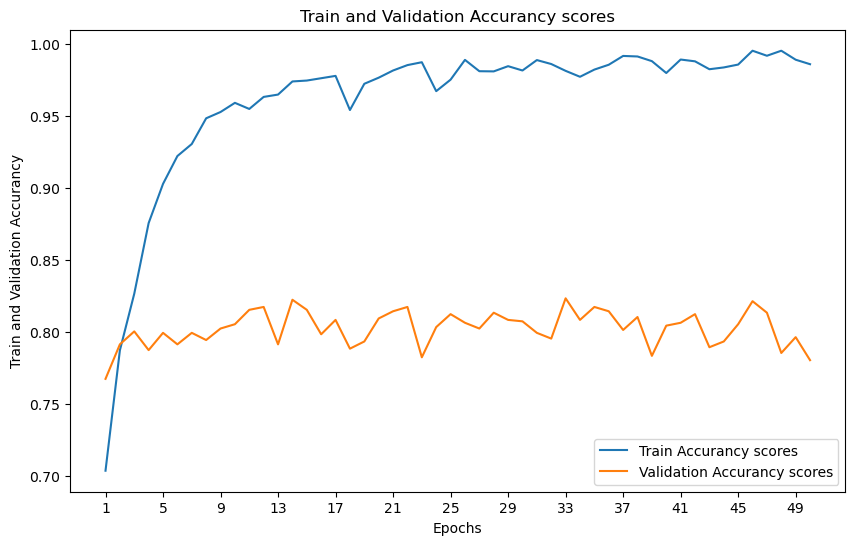

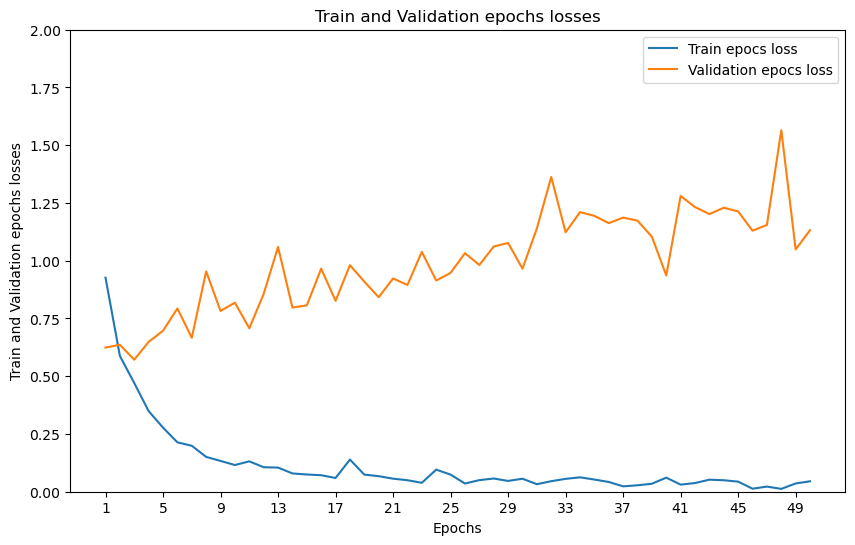

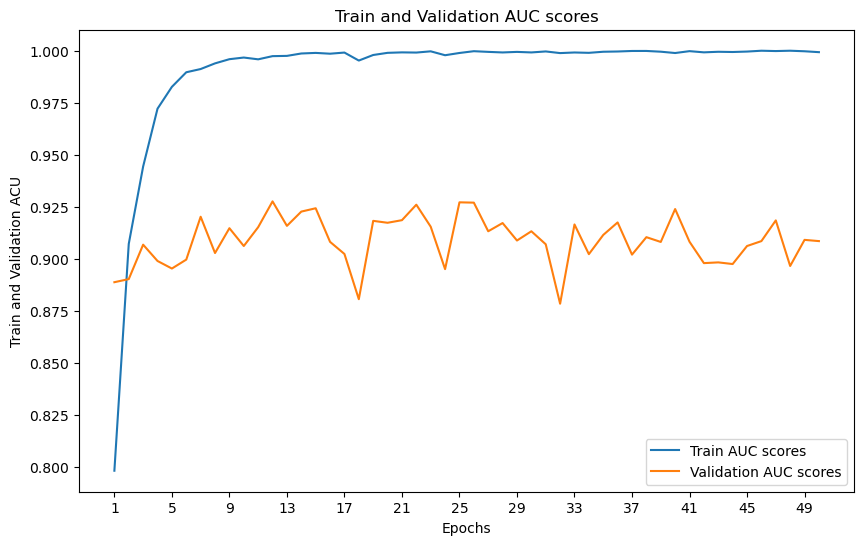

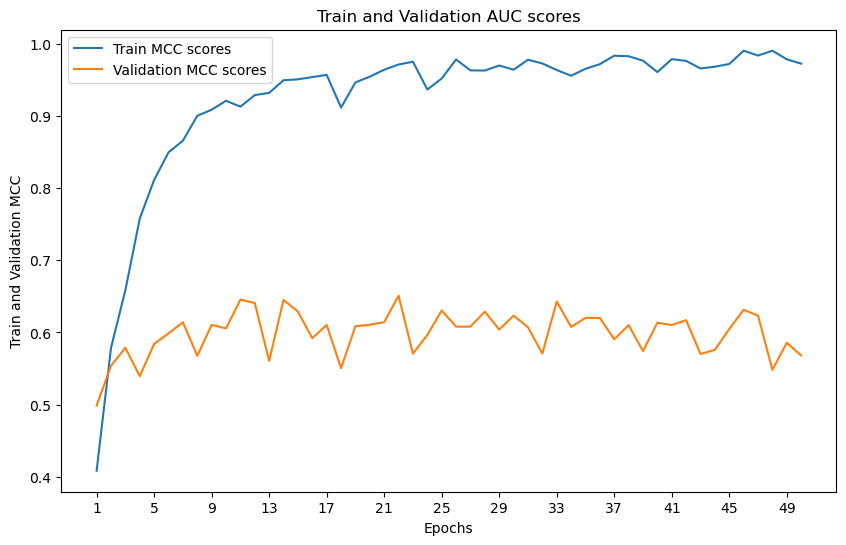

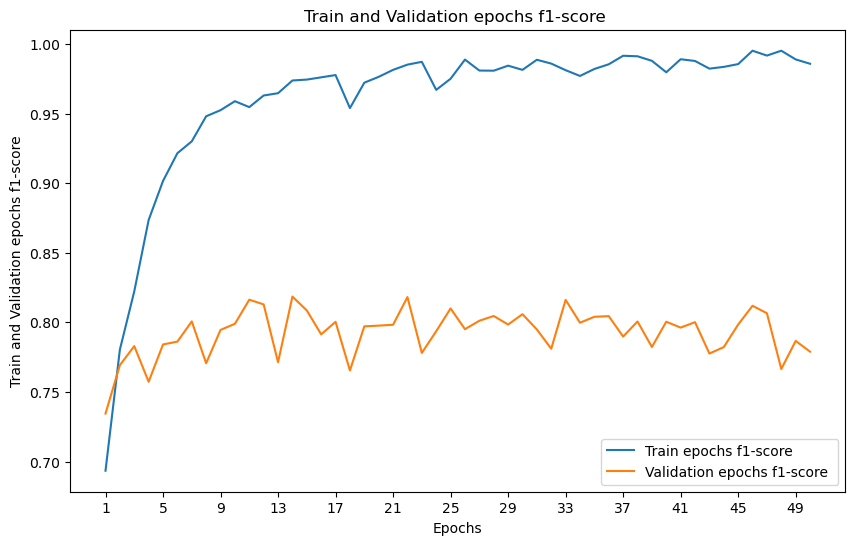

In [35]:
class plots():
    def __init__(self, r):
        plt.figure(figsize=(10, 6))
        plt.plot(r["tr_acc_sc"], label ="Train Accurancy scores")
        plt.plot(r["val_acc_sc"], label = "Validation Accurancy scores")
        plt.title("Train and Validation Accurancy scores")
        plt.xlabel("Epochs")
        plt.ylabel("Train and Validation Accurancy")
        plt.xticks(np.arange(0, len(r["val_acc_sc"]), 4), [i for i in range(1, len(r["val_acc_sc"])+1,4 )])
        plt.legend()
      
        
        plt.show()

        plt.figure(figsize=(10, 6))
        plt.plot(r["tr_loss_acc"], label ="Train epocs loss")
        plt.plot(r["val_loss_acc"], label = "Validation epocs loss")
        plt.title("Train and Validation epochs losses")
        plt.xlabel("Epochs")
        plt.ylim(0, 2)
        plt.ylabel("Train and Validation epochs losses")
        plt.xticks(np.arange(0, len(r["val_loss_acc"]), 4), [i for i in range(1, len(r["val_loss_acc"])+1, 4)])
        plt.legend()
        plt.show()

        plt.figure(figsize=(10, 6))
        plt.plot(r["tr_auc_sc"], label ="Train AUC scores")
        plt.plot(r["val_auc_sc"], label = "Validation AUC scores")
        plt.title("Train and Validation AUC scores")
        plt.xlabel("Epochs")
        plt.ylabel("Train and Validation ACU")
        plt.xticks(np.arange(0, len(r["val_auc_sc"]), 4), [i for i in range(1, len(r["val_auc_sc"])+1, 4)])
        plt.legend()
        plt.show()

        plt.figure(figsize=(10, 6))
        plt.plot(r["tr_mcc_sc"], label ="Train MCC scores")
        plt.plot(r["val_mcc_sc"], label = "Validation MCC scores")
        plt.title("Train and Validation AUC scores")
        plt.xlabel("Epochs")
        plt.ylabel("Train and Validation MCC")
        plt.xticks(np.arange(0, len(r["val_auc_sc"]), 4), [i for i in range(1, len(r["val_auc_sc"])+1, 4)])
        plt.legend()
        plt.show()

        plt.figure(figsize=(10, 6))
        plt.plot(r["tr_f1_sc"], label ="Train epochs f1-score")
        plt.plot(r["val_f1_sc"], label = "Validation epochs f1-score ")
        plt.title("Train and Validation epochs f1-score ")
        plt.xlabel("Epochs")
        plt.ylabel("Train and Validation epochs f1-score")
        plt.xticks(np.arange(0, len(r["val_f1_sc"]), 4), [i for i in range(1, len(r["val_f1_sc"])+1, 4)])
        plt.legend()
        plt.show()

plots(result)

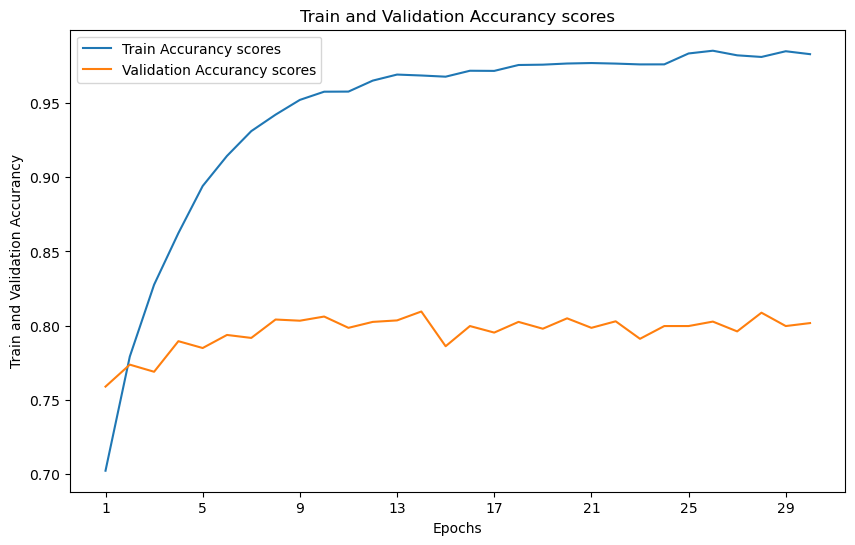

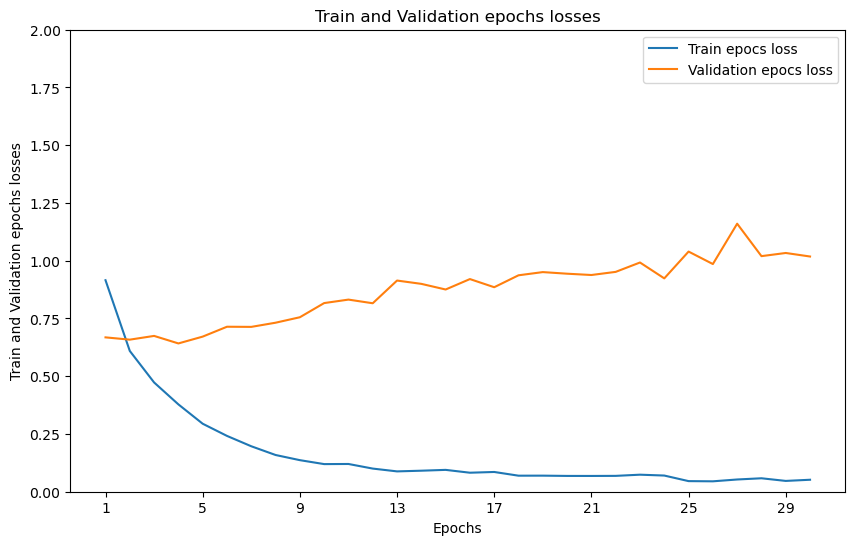

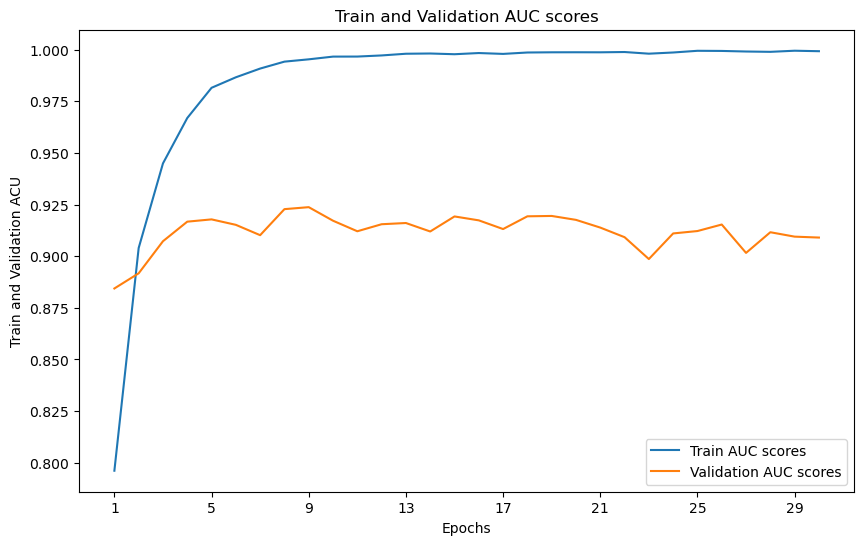

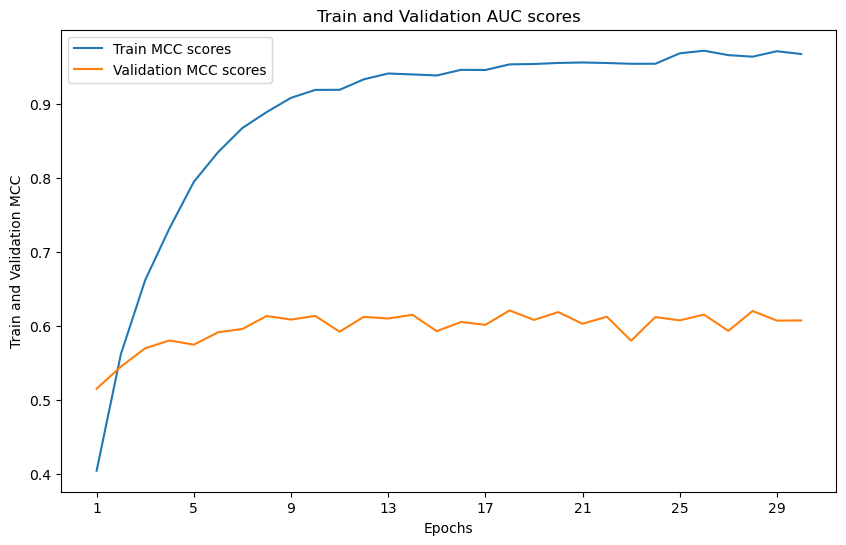

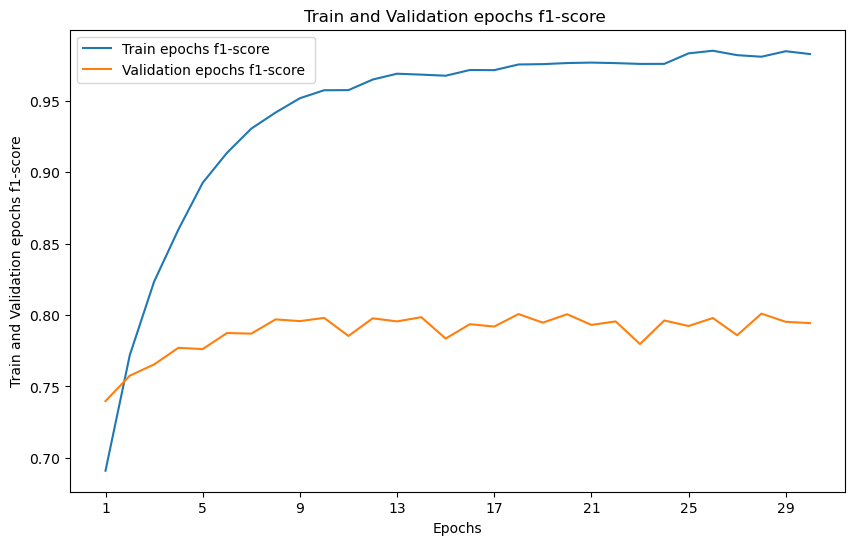

In [25]:
tr_acc_all = np.array([fold["tr_acc_sc"] for fold in fold_result])
val_acc_all = np.array([fold["val_acc_sc"] for fold in fold_result])

tr_loss_all = np.array([fold["tr_loss_acc"] for fold in fold_result])
val_loss_all = np.array([fold["val_loss_acc"] for fold in fold_result])

tr_auc_all = np.array([fold["tr_auc_sc"] for fold in fold_result])
val_auc_all = np.array([fold["val_auc_sc"] for fold in fold_result])

tr_mcc_all = np.array([fold["tr_mcc_sc"] for fold in fold_result])
val_mcc_all = np.array([fold["val_mcc_sc"] for fold in fold_result])

tr_f1_all = np.array([fold["tr_f1_sc"] for fold in fold_result])
val_f1_all = np.array([fold["val_f1_sc"] for fold in fold_result])

tr_acc_mean =  np.mean(tr_acc_all  , axis = 0)
val_acc_mean =  np.mean(val_acc_all , axis = 0)
tr_loss_mean = np.mean(tr_loss_all , axis = 0)
val_loss_mean = np.mean(val_loss_all , axis = 0)
tr_auc_mean = np.mean(tr_auc_all  , axis = 0)
val_auc_mean = np.mean(val_auc_all , axis = 0)
tr_mcc_mean = np.mean(tr_mcc_all  , axis = 0)
val_mcc_mean  = np.mean(val_mcc_all , axis = 0)
tr_f1_mean =  np.mean(tr_f1_all  , axis = 0)
val_f1_mean = np.mean(val_f1_all  , axis = 0)


mean_results = {
    "tr_acc_sc": list(tr_acc_mean ),
    "val_acc_sc": list(val_acc_mean),
    "tr_loss_acc": list(tr_loss_mean),
    "val_loss_acc": list(val_loss_mean),
    "tr_auc_sc": list(tr_auc_mean ),
    "val_auc_sc": list(val_auc_mean),
    "tr_mcc_sc": list(tr_mcc_mean ),
    "val_mcc_sc": list(val_mcc_mean),
    "tr_f1_sc": list(tr_f1_mean ),
    "val_f1_sc": list(val_f1_mean )


}

plots(mean_results)

# Inference for K-fold

Processing Fold 1/5 ....
Fold 1 Test Metrics:
Test Loss: 0.627 
Test Accuracy: 0.763
Processing Fold 2/5 ....
Fold 2 Test Metrics:
Test Loss: 0.639 
Test Accuracy: 0.800
Processing Fold 3/5 ....
Fold 3 Test Metrics:
Test Loss: 0.666 
Test Accuracy: 0.798
Processing Fold 4/5 ....
Fold 4 Test Metrics:
Test Loss: 0.596 
Test Accuracy: 0.784
Processing Fold 5/5 ....
Fold 5 Test Metrics:
Test Loss: 0.494 
Test Accuracy: 0.828
AUC Score: 0.943
MCC Score: 0.587

Final Metrics (5-fold):
Final Accuracy: 0.795
Final Loss: 0.605


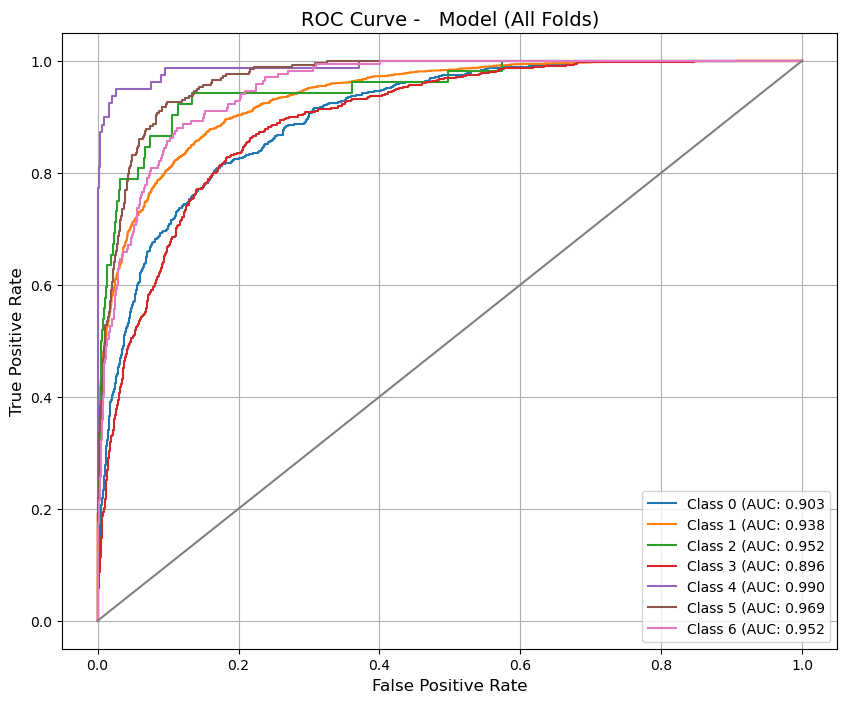


 Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.53      0.56       554
           1       0.87      0.94      0.90      3346
           2       0.45      0.42      0.44        52
           3       0.62      0.40      0.48       556
           4       0.90      0.80      0.85        79
           5       0.62      0.58      0.60       256
           6       0.54      0.46      0.49       167

    accuracy                           0.80      5010
   macro avg       0.65      0.59      0.62      5010
weighted avg       0.78      0.80      0.78      5010



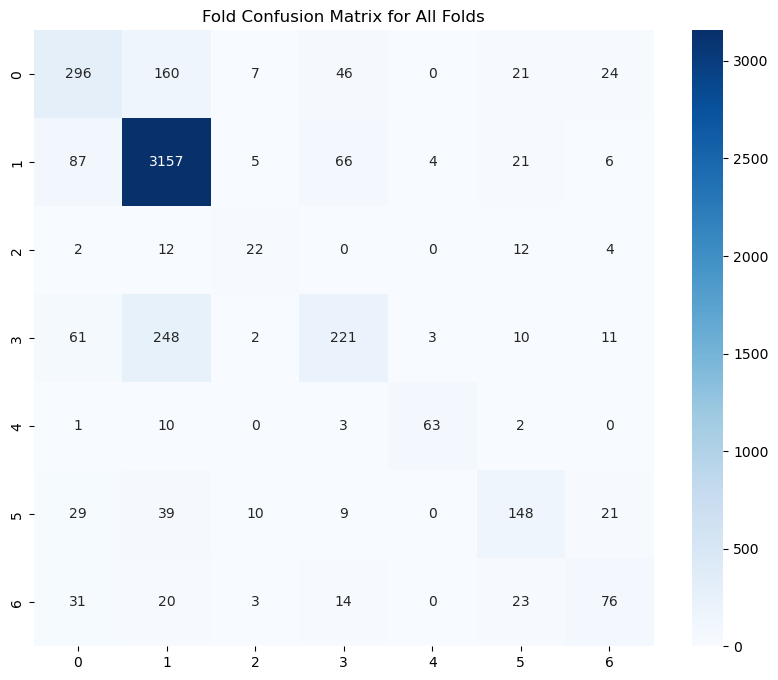

In [27]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve
import seaborn as sns
from sklearn.preprocessing import label_binarize
num_fold = 5
test_save_path = "test_data"
save_dir = "Skin_save_model_rexnet"
data = Customdataset(root=root, transform=trf)




# List to store from all folds

all_probs = []
all_gts = []
all_losses = []
all_accuracies = []

for fold in range(num_fold):
    print(f'Processing Fold {fold+1}/{num_fold} ....')
    test = os.path.join(test_save_path, f"test_indices_fold_{fold+1}.pkl")
    with open(test, "rb") as f:
        test_idx = pickle.load(f)
    fold_probs = []
    fold_gt = []
    fold_loss = 0.0
    test_subset = Subset(data, test_idx)
    test_dl = DataLoader(test_subset, batch_size = 1, shuffle = False, num_workers = 0)

     # Load model 
    model.load_state_dict(torch.load(f"{save_dir}/pkd4_fold{fold+1}_best_model.pth", weights_only=True))
    model.to(device)
    model.eval()

    with torch.no_grad():
        for batch in test_dl:
            im, gt = batch
            im, gt = im.to(device), gt.to(device)
            pred = model(im)
            prob = torch.softmax(pred, dim =1).cpu().numpy()
            loss = loss_fn(pred, gt)
            fold_loss+= loss.item()

            fold_probs.append(prob)
            fold_gt.append(gt.cpu().numpy())
            
        fold_probs = np.vstack(fold_probs)
        fold_gt = np.concatenate(fold_gt)

        # Store fold result
        all_probs.append(fold_probs)
        all_gts.append(fold_gt)
        all_losses.append(fold_loss/len(test_dl.dataset))

        # Compute Fold Accuracy
        fold_preds = np.argmax(fold_probs, axis=1)
        fold_acc  = (fold_preds == fold_gt).mean()
        all_accuracies.append(fold_acc)

        print(f"Fold {fold+1} Test Metrics:")
        print(f"Test Loss: {fold_loss/len(test_dl.dataset):.3f} ")
        print(f"Test Accuracy: {fold_acc:.3f}")
        
# Concatenate all probabilities and ground truths across folds
final_probs = np.vstack(all_probs)
all_gts_concat = np.concatenate(all_gts)

# Compute final prediction

final_preds = np.argmax(final_probs, axis=1)

final_acc = (final_preds == all_gts_concat).mean()

final_loss = np.mean(all_losses)

# F1 score
f1 = f1_score(all_gts_concat, final_preds,  average='weighted')
# AUC
auc = roc_auc_score(all_gts_concat, final_probs, multi_class="ovr")
# MCC
mcc = matthews_corrcoef(all_gts_concat, final_preds)

print(f"AUC Score: {auc:.3f}")
print(f"MCC Score: {mcc:.3f}")

print(f"\nFinal Metrics ({num_fold}-fold):")
print(f"Final Accuracy: {final_acc:.3f}")
print(f"Final Loss: {final_loss:.3f}")

# ROC Corve
n_classes = len(np.unique(all_gts_concat))
y_true_bin = label_binarize(all_gts_concat, classes=np.arange(n_classes))
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    fpr, tpr, _ =  roc_curve(y_true_bin[:,i], final_probs[:,i])
    plt.plot(fpr, tpr, label = f"Class {i} (AUC: {roc_auc_score(y_true_bin[:,i], final_probs[:,i]):.3f}")
plt.plot([0,1], [0, 1], linestyle = "-", color = "gray")
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve -   Model (All Folds)', fontsize=14)
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Classification report

print("\n Classification Report:")
print(classification_report(all_gts_concat, final_preds))
cm = confusion_matrix(all_gts_concat, final_preds)

plt.figure(figsize = (10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap = "Blues")
plt.title("Fold Confusion Matrix for All Folds")
plt.show()
        
            
    

# inference without k-fold

Inference: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 1002/1002 [00:10<00:00, 93.97it/s]


Test Accuracy: 0.763
Test Loss: 0.688
Test F1 Score: 0.747
Test AUC: 0.909
Test MCC: 0.529


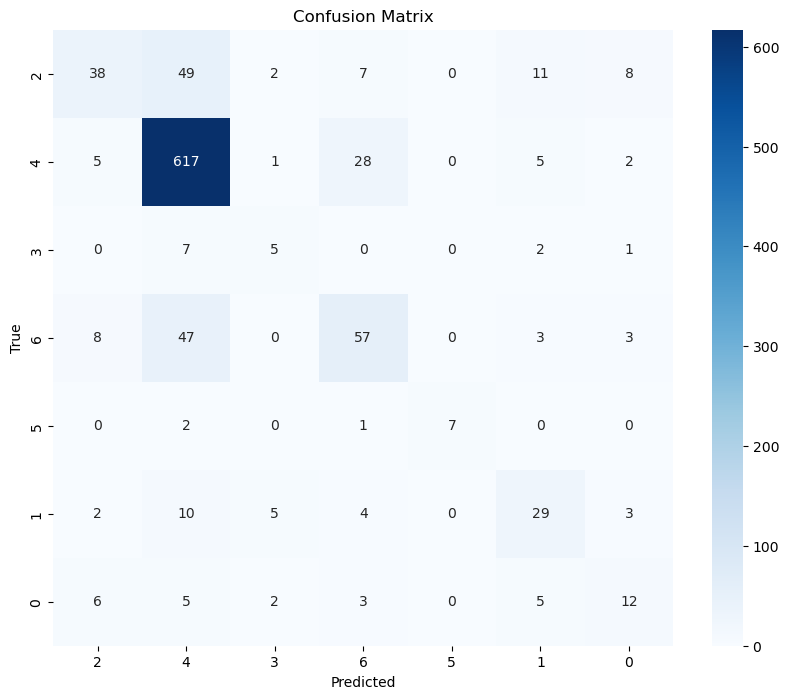

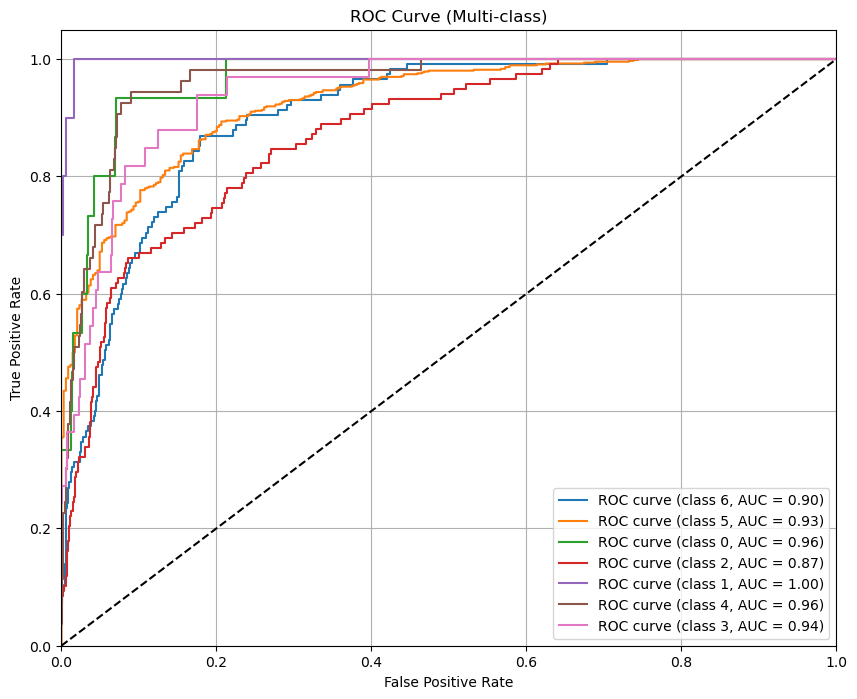

In [44]:
import torch
import numpy as np
from sklearn.metrics import roc_auc_score, f1_score, matthews_corrcoef, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import os

def inference(model, test_dl, device, num_classes = None, class_names=None):
    model.eval()
    test_loss, test_acc = 0, 0
    test_probs, test_labels, test_preds = [], [], []
    loss_fn = torch.nn.CrossEntropyLoss()

    with torch.no_grad():
        for idx, batch in enumerate(tqdm(test_dl, desc="Inference")):
            im, gt = batch
            im, gt = im.to(device), gt.to(device)
            pred = model(im)
            loss = loss_fn(pred, gt)
            
            test_loss += loss.item()
            pred_class = torch.argmax(pred, dim=1)
            test_acc += (pred_class == gt).sum().item()
            
            test_probs.extend(torch.softmax(pred, dim=1).detach().cpu().numpy())
            test_labels.extend(gt.cpu().numpy())
            test_preds.extend(pred_class.cpu().numpy())

    test_acc /= len(test_dl.dataset)
    test_loss /= len(test_dl)
    test_f1 = f1_score(test_labels, test_preds, average='weighted')
    test_mcc = matthews_corrcoef(test_labels, test_preds)
    test_auc = roc_auc_score(test_labels, test_probs, multi_class="ovo")

    # Print metrics
    print(f"Test Accuracy: {test_acc:.3f}")
    print(f"Test Loss: {test_loss:.3f}")
    print(f"Test F1 Score: {test_f1:.3f}")
    print(f"Test AUC: {test_auc:.3f}")
    print(f"Test MCC: {test_mcc:.3f}")

    # Confusion Matrix
    cm = confusion_matrix(test_labels, test_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names if class_names else range(num_classes),
                yticklabels=class_names if class_names else range(num_classes))
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # ROC Curve for multi-class
    test_probs = np.array(test_probs)
    test_labels_bin = np.eye(num_classes)[test_labels]  # One-hot encoding for ROC
    
    plt.figure(figsize=(10, 8))
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(test_labels_bin[:, i], test_probs[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'ROC curve (class {class_names[i] if class_names else i}, AUC = {roc_auc:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve (Multi-class)')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

    return {
        "test_loss": test_loss,
        "test_acc": test_acc,
        "test_f1": test_f1,
        "test_auc": test_auc,
        "test_mcc": test_mcc,
        "confusion_matrix": cm
    }


model = timm.create_model('rexnet_150', pretrained=False, num_classes=len(class_names))  # Adjust model
model.load_state_dict(torch.load("Skin_save_model_rexnet_/pkd4_fold5_best_model.pth"))  # Load trained model
model.to(device)

num_classes = len(class_names)
# Assuming test_dl is your test dataloader
results = inference(model, ts_dl, device, num_classes, class_names)


In [74]:
import torch.nn.functional as F
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
from skimage.transform import resize
from lime import lime_image
from PIL import Image

# Generate XAI with LIME

In [60]:

def generate_superpixels(im, n_segments, compactness):
    img_arr = np.array(im)
    segments = slic(img_arr, n_segments = n_segments, compactness = compactness)
    super_pix = mark_boundaries(img_arr , segments)
    super_pix_uintt8 = (super_pix*255).astype(np.uint8)
    super_img = Image.fromarray(super_pix_uintt8)
    return super_img

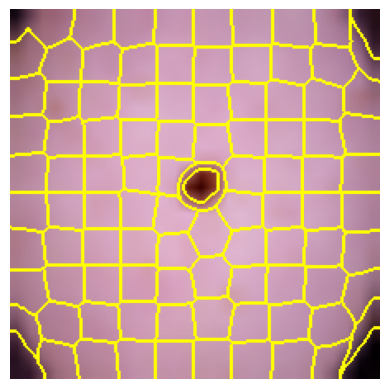

In [131]:

# Process images from ts_dl
test = []
for batch in ts_dl:
    images = batch[0]
    for im in images:  
        test.append(tr_2_im(im)) 

img = generate_superpixels(test[10], 100, 20)
plt.imshow(img)
plt.axis('off')  
plt.show()

Input image shape: (224, 224, 3)


  0%|          | 0/1000 [00:00<?, ?it/s]

Mask shape: (224, 224), Temp shape: (224, 224, 3)


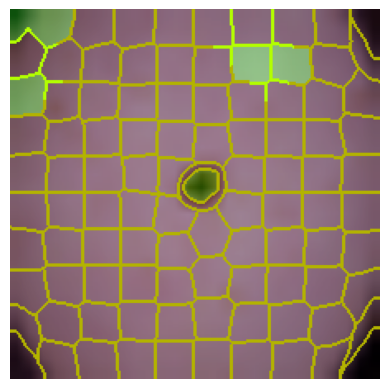

In [132]:

def predict_fn(images):
    batch_size = 32
    probabilities = []
    images = torch.from_numpy(images).permute(0, 3, 1, 2).float() / 255.0
    images = images.to(device)
    with torch.no_grad():
        for i in range(0, len(images), batch_size):
            batch_images = images[i:i + batch_size]
            outputs = model(batch_images)
            probs = torch.softmax(outputs, dim=1)
            probabilities.append(probs.cpu().numpy())
    return np.concatenate(probabilities, axis=0)


# generate_superpixels (from previous context)
def generate_superpixels(im, n_segments, compactness):
    img_arr = np.array(im)
    segments = slic(img_arr, n_segments=n_segments, compactness=compactness)
    super_pix = mark_boundaries(img_arr, segments)
    super_pix_uint8 = (super_pix * 255).astype(np.uint8)
    super_img = Image.fromarray(super_pix_uint8)
    return super_img

# Updated generate_xai_images
def generate_xai_images():
    img = generate_superpixels(test[10], 100, 20)  # PIL Image
    img_array = np.array(img)  # [height, width, 3]
    print(f"Input image shape: {img_array.shape}")  # Debug

    exp = LimeImageExplainer()
    explanation = exp.explain_instance(
        img_array,
        predict_fn,
        top_labels=6,
        hide_color=0,
        num_samples=1000
    )
    
    temp, mask = explanation.get_image_and_mask(
        explanation.top_labels[1],
        positive_only=True,
        num_features=5,
        hide_rest=False
    )
    print(f"Mask shape: {mask.shape}, Temp shape: {temp.shape}")  # Debug

    # Resize mask to match desired output size (418, 556)
    mask_resized = resize(mask, (224, 224), anti_aliasing=True, preserve_range=True)
    mask_3d = np.zeros((224, 224, 3))
    mask_3d[:, :, 1] = mask_resized  # Assign to green channel for visualization

    plt.figure()
    plt.imshow(temp)  
    plt.imshow(mask_3d, alpha=0.3)  
    plt.axis('off')
    plt.show()
    
    return temp, mask_3d

# Generate test list from ts_dl (from previous context)
test = []
for batch in ts_dl:
    images = batch[0] if isinstance(batch, (list, tuple)) else batch
    for im in images:
        test.append(tr_2_im(im))

# Run the function
temp, mask = generate_xai_images()